# Advance Lane Lines Project



The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
# Importing the libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import math
#%matplotlib qt
import pickle

### Camera Calibration

It calculates the correct camera matrix by using the calibration chessboard images provided. 

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function.

In [190]:
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

# Reading all the calibration images present in the camera_cal folder.
images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #Finding chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    name = fname.split('\\')[1]
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #Drawing the detected corners on the image
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        #Saving all the images in the output_images folder
        cv2.imwrite('output_images/'+name,img)
        cv2.waitKey(500)
    else:
        print("false")
        
        
cv2.destroyAllWindows()

false
false
false


### Undistorted Image

Using the distortion matrix to undistort the calibration images. All the undistorted images are saved in folder:
"output_images"



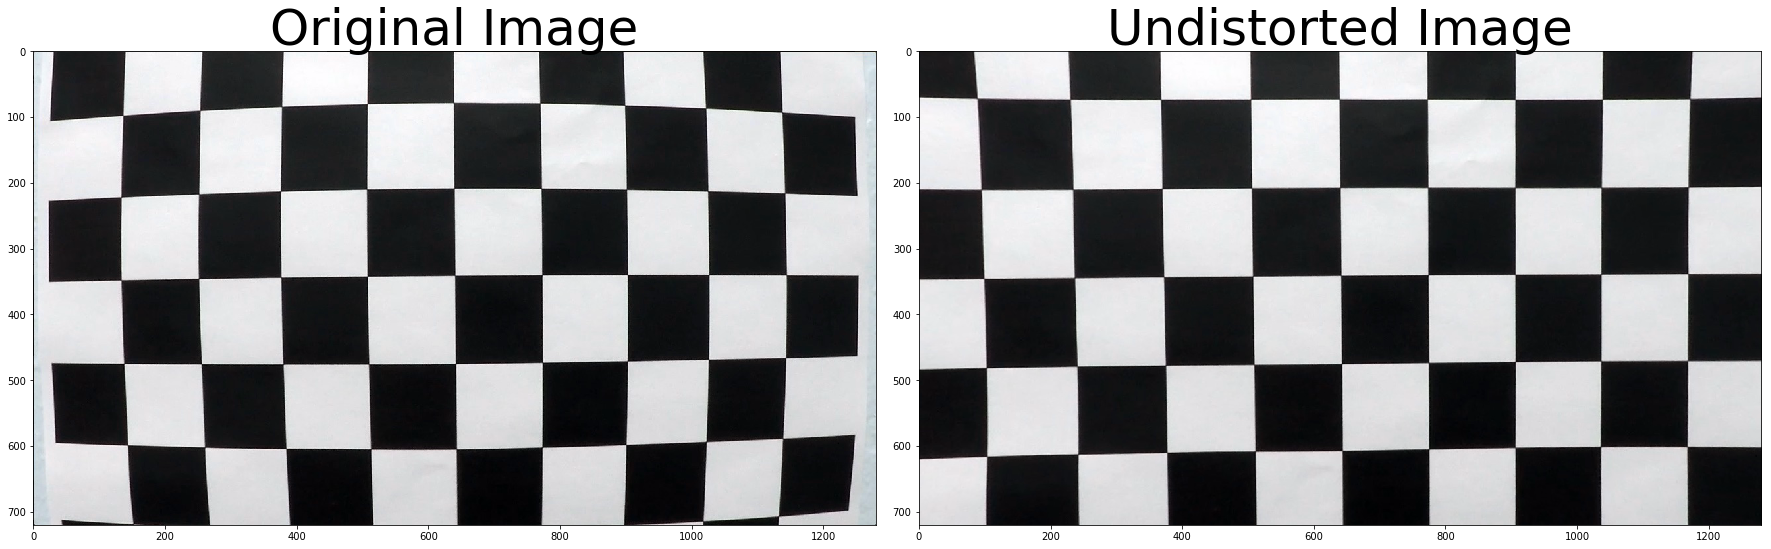

In [162]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
undist = cv2.undistort(img, mtx, dist, None, mtx)

#Visualization of the original image and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [ ]:
# Saving the camera calibration result in pickel file for later use.
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

In [8]:
# Reading the pickle file to get the already calculated calibration result.
    
camera_cal_file = 'calibration.p'

with open(camera_cal_file, mode='rb') as f:
    camera_cal = pickle.load(f)

mtx, dist = camera_cal['mtx'], camera_cal['dist']

Applying the undistort function to the test images. Here is an example of one of the image. All the images are saved in the folder: "output_images"

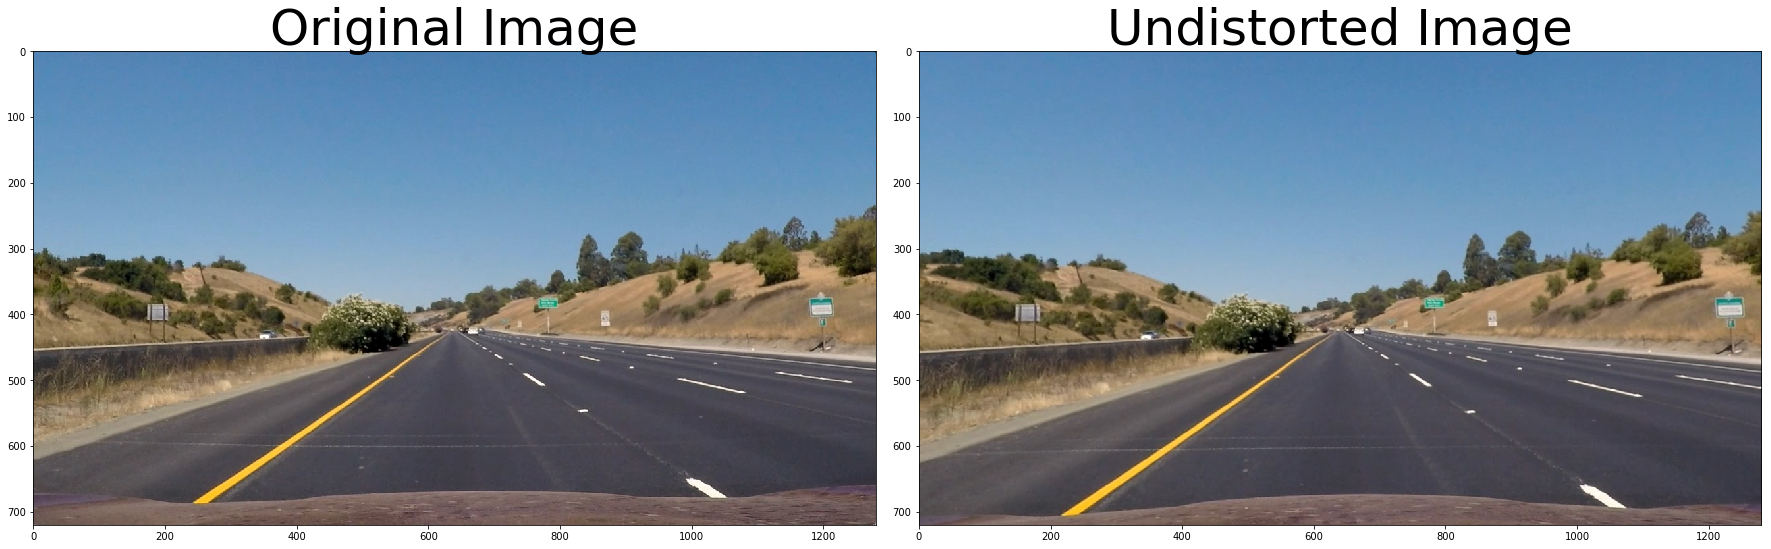

In [233]:
# Reading one of the test image
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

#Using undistort function of OpenCv
dst = cv2.undistort(img, mtx, dist, None, mtx)
# Visualizing the undistortion on the test image.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective Transform

Finding the source and destination points from the test image and using OpenCV functions getPerspectiveTransform to find the transformed matrix and warpPerspective for warping the image. 


In [234]:
# Function  takes undistorted image, number of x and y points, camera matrix and distortion
def corners_unwarp(img, nx, ny, mtx, dist):
    #Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    width = gray.shape[1]
    height = gray.shape[0]
    img_poly = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    # For source points, taking the four corners of the lanes
    src = np.float32([[(220,720),(1110,720),(722,470),(570 ,470) ]])
    # For destination points, taking the four points to image to have proper fit.
    dst = np.float32([[(200,0),(1080,0),(1080,720),(200,720)]])
    #cv2.polylines(gray, np.int32([src]), 5, (255,255,255))
    img_poly = cv2.polylines(img_poly,np.int32([src]),True,(255,0,0), 5)
    plt.imshow(img_poly)
    # Calculating the perspective transform matrix                                 
    M = cv2.getPerspectiveTransform(src, dst)        
    # Calculating the inverse perspective transform matrix   
    Minv =  cv2.getPerspectiveTransform(dst, src)
    # Warping the image
    warped = cv2.warpPerspective(img, M, img_size)

    # Returning the image, matrix and the inverse matrix
    return warped, M, Minv



### Sobel Operator

Function to apply the sobel on the image, which takes an absolute value and applies the threshold. It used the OpenCV function Sobel to do the same. Required threshold values (min and max) to be passed in the function accordingly. 

In [164]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Applying x or y gradient and taking the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    #Rescaling to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #Creating the copy to apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output
    

#### Function that thresholds the S-channel of HLS

In [25]:
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_output

#### Magnitude of the Gradient

Function to get the magnitude of the gradient for the given sobel kernel and the threshold values. 

In [26]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


#### Direction of the Threshold
Function to threshold the image for the given sobel kernel and the range.

In [27]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale conversion
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

#### Visualizing the functions on the test image. 



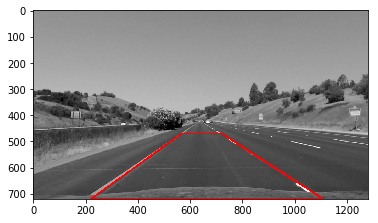

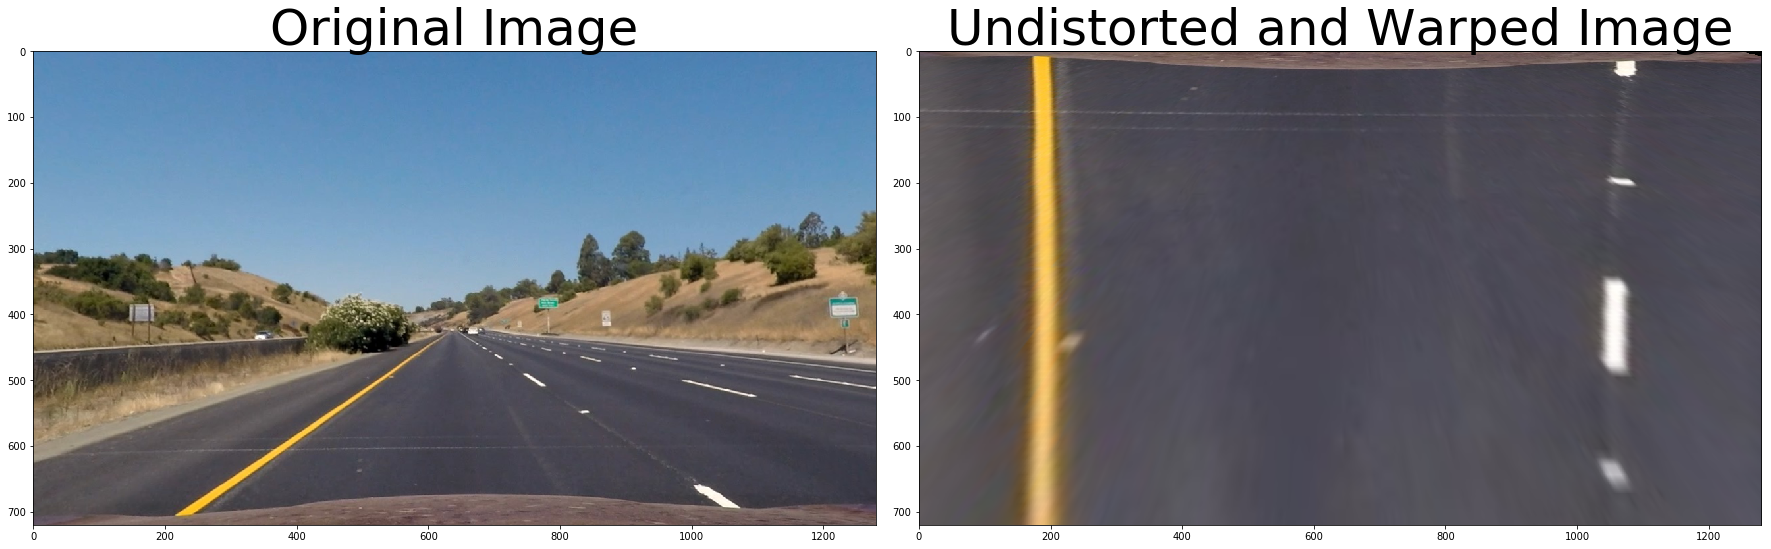

In [235]:
# Warping the distorted image. 
top_down, perspective_M, Minv = corners_unwarp(dst, 9, 6, mtx, dist)
#Visualizing the undistorted and warped image. 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

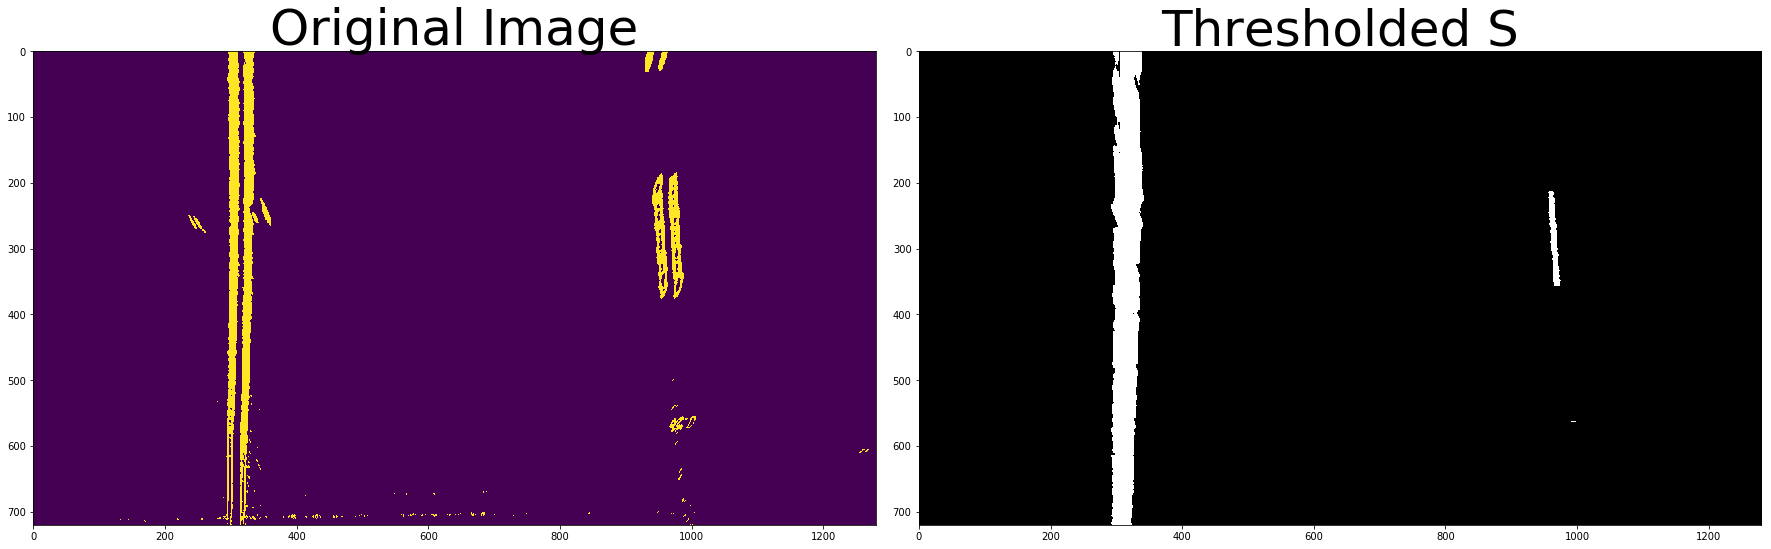

In [62]:
hls_binary = hls_select(top_down, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(grad_binary_x)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#### Finding the binary output image using the above defined functions (On the original image)

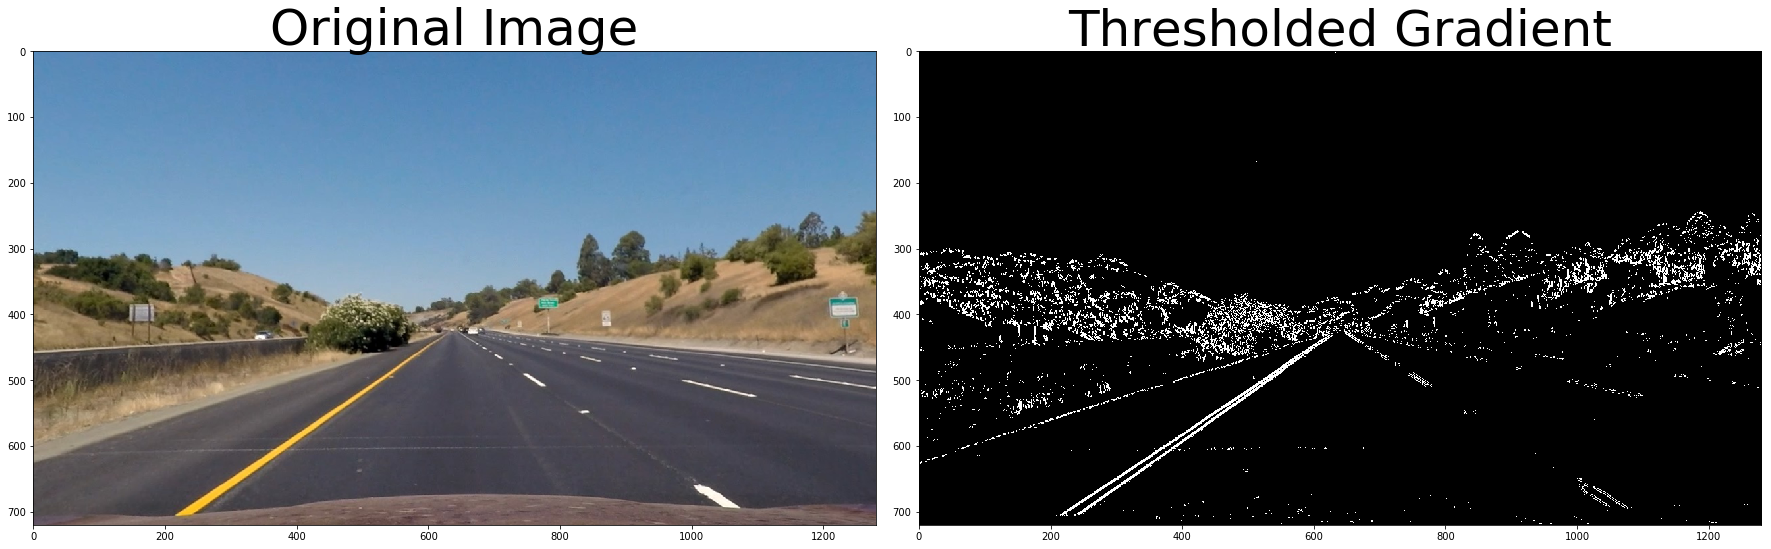

In [57]:
ksize = 3 # Kernel size for Sobel

# Calculating the x and y gradients
gradx = abs_sobel_thresh(dst, orient='x', thresh_min = 10, thresh_max = 230)
grady = abs_sobel_thresh(dst, orient='y', thresh_min = 10, thresh_max = 230)
# Calculating gradient magnitude
mag_binary = mag_thresh(dst, sobel_kernel=ksize, mag_thresh=(30, 150))
# Calculating gradient direction
dir_binary = dir_threshold(dst, sobel_kernel=ksize, thresh=(0.7, 1.3))
# Threshold the S channel of HLS
hls_binary = hls_select(dst, thresh=(80, 255))
combined = np.zeros_like(dir_binary)

# Combining the output from above and getting the binary output 
combined[((gradx == 1) & (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Finding the binary output image using the above defined functions (On the warped image)

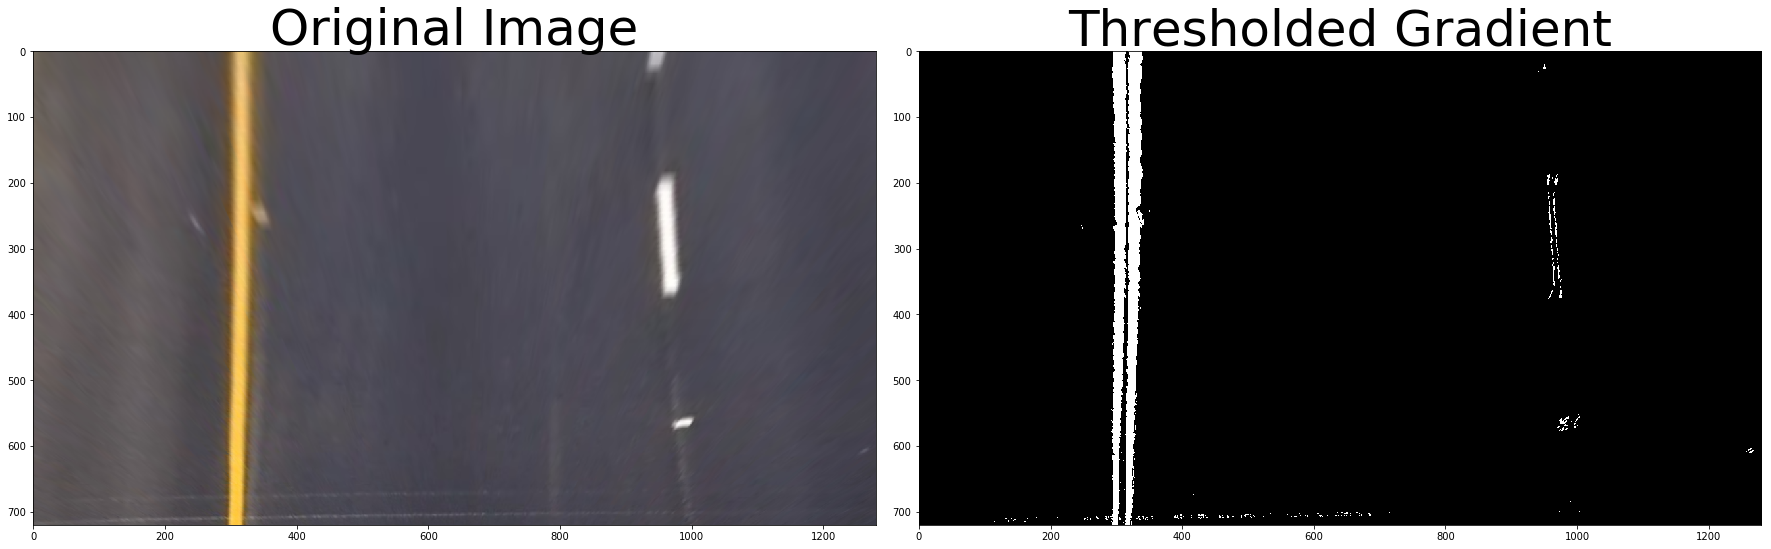

In [166]:
ksize = 3 # Kernel size for Sobel

# Calculating the x and y gradients
gradx = abs_sobel_thresh(top_down, orient='x', thresh_min = 10, thresh_max = 230)
grady = abs_sobel_thresh(top_down, orient='y', thresh_min = 10, thresh_max = 230)
# Calculating gradient magnitude
mag_binary = mag_thresh(top_down, sobel_kernel=ksize, mag_thresh=(30, 150))
# Calculating gradient direction
dir_binary = dir_threshold(top_down, sobel_kernel=ksize, thresh=(0.7, 1.3))
# Threshold the S channel of HLS
hls_binary = hls_select(top_down, thresh=(80, 255))
combined = np.zeros_like(dir_binary)
# Combining the output from above and getting the binary output 
combined[((gradx == 1) & (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(top_down)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Pipeline Function to process individual images and video 

1. Undistort the image
2. Finding Perspective Transform of the image
3. Calculating the gradients and threshold the S channel, then combining the same.
4. Identified lane-line pixels and fit their positions with a polynomial. 

        Next, I am identifying the pixels which are associated with the lane lines. Taking the histogram of the bottom half of the image and finding the peak of left and right halves of the same. Using the sliding windows, placing it around the line centers to find and follow the lines up to the top of the frame.
        Then drawing the lane onto the warped blank image and the same to original image space.

5.  Radius of curvature of the lane and the position of the vehicle with respect to center.

        We need to define y-value where we want radius of curvature, I chose maximum y-value, corresponding to the bottom of the image. Used polynomial fit for the lane lines. Converted the x and y from pixels to meters. Fitted the new polynomials to x,y. Also, calculated the vehicle position from the center using the polynomial fit for the lane lines. Converted the above values in meters. 

In [205]:
def pipeline(img):
    
    width = img.shape[1]
    height = img.shape[0]
    dst = cv2.undistort(img, mtx, dist, None, mtx) # Undistort the image
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB) # Convert to RGB
    # Warping the undistorted image
    top_down, perspective_M, Minv = corners_unwarp(dst, 9, 6, mtx, dist)

    ksize = 3 # Kernel size for Sobel
    # Calculating the x and y gradients
    gradx = abs_sobel_thresh(top_down, orient='x', thresh_min = 10, thresh_max = 230)
    grady = abs_sobel_thresh(top_down, orient='y', thresh_min = 10, thresh_max = 230)
    # Calculating gradient magnitude
    mag_binary = mag_thresh(top_down, sobel_kernel=ksize, mag_thresh=(30, 150))
    # Calculating gradient direction
    dir_binary = dir_threshold(top_down, sobel_kernel=ksize, thresh=(0.7, 1.3))
    # Threshold the S channel of HLS
    hls_binary = hls_select(top_down, thresh=(80, 255))
    combined = np.zeros_like(dir_binary)
    # Combining the output from above and getting the binary output 
    combined[((gradx == 1) & (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    ############################Finding the Lines#################################
    # Take a histogram of the bottom half of the image
    histogram = np.sum(combined[int(combined.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on
    out_img = np.dstack((combined, combined, combined))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(combined.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = combined.shape[0] - (window+1)*window_height
        win_y_high = combined.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    
    ######## Drawing the lanes #################
    # Draw the lane onto the warped blank image
    window_img = np.zeros_like(out_img)
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    warp_zero = np.zeros_like(combined).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (dst.shape[1], dst.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    ###### Finding Radius of Curvature ######################
    
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    print (len(ploty))
        
    fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    # Radius of curvature is in meters
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    font = cv2.FONT_HERSHEY_SIMPLEX

    cv2.putText(result, 'Radius of Curvature '+ str(curverad)[:6], (20,40), font, 1, (255,255,255), 2)
    
    ##### Finding the Distance from the center #################
    x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    midx = 650
    offset = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
    cv2.putText(result,'Distance From Center ' + str(offset)[:6],(20,100), font, 1,(255,255,255),2)


    plt.imshow(result)
    return result

## Processing the pipeline on the image

Below is the example processed image. Also, saved in the "output_images" folder.

720


True

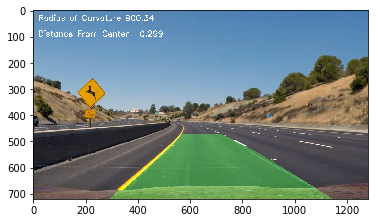

In [206]:
img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = pipeline(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite('output_images/test2.jpg',img)

## Video Processing

Processing the pipeline on the project video. Video saved as "project_video_out.mp4". 


720
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

720


  0%|                                                                                 | 1/1261 [00:00<08:19,  2.52it/s]

720


  0%|▏                                                                                | 2/1261 [00:00<08:25,  2.49it/s]

720


  0%|▏                                                                                | 3/1261 [00:01<08:37,  2.43it/s]

720


  0%|▎                                                                                | 4/1261 [00:01<08:27,  2.48it/s]

720


  0%|▎                                                                                | 5/1261 [00:01<08:14,  2.54it/s]

720


  0%|▍                                                                                | 6/1261 [00:02<08:09,  2.57it/s]

720


  1%|▍                                                                                | 7/1261 [00:02<08:22,  2.50it/s]

720


  1%|▌                                                                                | 8/1261 [00:03<08:31,  2.45it/s]

720


  1%|▌                                                                                | 9/1261 [00:03<08:14,  2.53it/s]

720


  1%|▋                                                                               | 10/1261 [00:03<08:06,  2.57it/s]

720


  1%|▋                                                                               | 11/1261 [00:04<08:02,  2.59it/s]

720


  1%|▊                                                                               | 12/1261 [00:04<07:56,  2.62it/s]

720


  1%|▊                                                                               | 13/1261 [00:05<08:50,  2.35it/s]

720


  1%|▉                                                                               | 14/1261 [00:05<09:08,  2.27it/s]

720


  1%|▉                                                                               | 15/1261 [00:06<08:56,  2.32it/s]

720


  1%|█                                                                               | 16/1261 [00:06<09:29,  2.19it/s]

720


  1%|█                                                                               | 17/1261 [00:07<09:09,  2.26it/s]

720


  1%|█▏                                                                              | 18/1261 [00:07<09:14,  2.24it/s]

720


  2%|█▏                                                                              | 19/1261 [00:07<08:54,  2.32it/s]

720


  2%|█▎                                                                              | 20/1261 [00:08<08:36,  2.40it/s]

720


  2%|█▎                                                                              | 21/1261 [00:08<08:21,  2.47it/s]

720


  2%|█▍                                                                              | 22/1261 [00:09<08:10,  2.52it/s]

720


  2%|█▍                                                                              | 23/1261 [00:09<08:08,  2.53it/s]

720


  2%|█▌                                                                              | 24/1261 [00:09<07:59,  2.58it/s]

720


  2%|█▌                                                                              | 25/1261 [00:10<07:51,  2.62it/s]

720


  2%|█▋                                                                              | 26/1261 [00:10<07:51,  2.62it/s]

720


  2%|█▋                                                                              | 27/1261 [00:10<07:53,  2.61it/s]

720


  2%|█▊                                                                              | 28/1261 [00:11<07:44,  2.65it/s]

720


  2%|█▊                                                                              | 29/1261 [00:11<07:47,  2.64it/s]

720


  2%|█▉                                                                              | 30/1261 [00:12<07:53,  2.60it/s]

720


  2%|█▉                                                                              | 31/1261 [00:12<07:41,  2.67it/s]

720


  3%|██                                                                              | 32/1261 [00:12<07:45,  2.64it/s]

720


  3%|██                                                                              | 33/1261 [00:13<08:09,  2.51it/s]

720


  3%|██▏                                                                             | 34/1261 [00:13<08:16,  2.47it/s]

720


  3%|██▏                                                                             | 35/1261 [00:14<08:32,  2.39it/s]

720


  3%|██▎                                                                             | 36/1261 [00:14<08:31,  2.40it/s]

720


  3%|██▎                                                                             | 37/1261 [00:14<08:24,  2.43it/s]

720


  3%|██▍                                                                             | 38/1261 [00:15<08:25,  2.42it/s]

720


  3%|██▍                                                                             | 39/1261 [00:15<08:14,  2.47it/s]

720


  3%|██▌                                                                             | 40/1261 [00:16<08:06,  2.51it/s]

720


  3%|██▌                                                                             | 41/1261 [00:16<08:05,  2.51it/s]

720


  3%|██▋                                                                             | 42/1261 [00:16<08:07,  2.50it/s]

720


  3%|██▋                                                                             | 43/1261 [00:17<08:24,  2.41it/s]

720


  3%|██▊                                                                             | 44/1261 [00:17<08:18,  2.44it/s]

720


  4%|██▊                                                                             | 45/1261 [00:18<09:03,  2.24it/s]

720


  4%|██▉                                                                             | 46/1261 [00:18<08:40,  2.33it/s]

720


  4%|██▉                                                                             | 47/1261 [00:19<08:16,  2.44it/s]

720


  4%|███                                                                             | 48/1261 [00:19<08:08,  2.48it/s]

720


  4%|███                                                                             | 49/1261 [00:19<08:05,  2.50it/s]

720


  4%|███▏                                                                            | 50/1261 [00:20<08:22,  2.41it/s]

720


  4%|███▏                                                                            | 51/1261 [00:20<08:31,  2.37it/s]

720


  4%|███▎                                                                            | 52/1261 [00:21<09:40,  2.08it/s]

720


  4%|███▎                                                                            | 53/1261 [00:21<09:15,  2.17it/s]

720


  4%|███▍                                                                            | 54/1261 [00:22<09:22,  2.14it/s]

720


  4%|███▍                                                                            | 55/1261 [00:22<08:53,  2.26it/s]

720


  4%|███▌                                                                            | 56/1261 [00:23<08:43,  2.30it/s]

720


  5%|███▌                                                                            | 57/1261 [00:23<08:53,  2.26it/s]

720


  5%|███▋                                                                            | 58/1261 [00:23<08:38,  2.32it/s]

720


  5%|███▋                                                                            | 59/1261 [00:24<08:33,  2.34it/s]

720


  5%|███▊                                                                            | 60/1261 [00:24<08:28,  2.36it/s]

720


  5%|███▊                                                                            | 61/1261 [00:25<08:55,  2.24it/s]

720


  5%|███▉                                                                            | 62/1261 [00:25<08:32,  2.34it/s]

720


  5%|███▉                                                                            | 63/1261 [00:26<08:14,  2.42it/s]

720


  5%|████                                                                            | 64/1261 [00:26<08:11,  2.44it/s]

720


  5%|████                                                                            | 65/1261 [00:26<08:54,  2.24it/s]

720


  5%|████▏                                                                           | 66/1261 [00:27<10:42,  1.86it/s]

720


  5%|████▎                                                                           | 67/1261 [00:28<11:13,  1.77it/s]

720


  5%|████▎                                                                           | 68/1261 [00:29<12:54,  1.54it/s]

720


  5%|████▍                                                                           | 69/1261 [00:29<11:29,  1.73it/s]

720


  6%|████▍                                                                           | 70/1261 [00:30<10:59,  1.81it/s]

720


  6%|████▌                                                                           | 71/1261 [00:30<11:09,  1.78it/s]

720


  6%|████▌                                                                           | 72/1261 [00:31<10:18,  1.92it/s]

720


  6%|████▋                                                                           | 73/1261 [00:31<09:53,  2.00it/s]

720


  6%|████▋                                                                           | 74/1261 [00:31<09:10,  2.15it/s]

720


  6%|████▊                                                                           | 75/1261 [00:32<09:05,  2.17it/s]

720


  6%|████▊                                                                           | 76/1261 [00:32<08:43,  2.26it/s]

720


  6%|████▉                                                                           | 77/1261 [00:33<08:32,  2.31it/s]

720


  6%|████▉                                                                           | 78/1261 [00:33<08:28,  2.33it/s]

720


  6%|█████                                                                           | 79/1261 [00:34<08:22,  2.35it/s]

720


  6%|█████                                                                           | 80/1261 [00:34<08:29,  2.32it/s]

720


  6%|█████▏                                                                          | 81/1261 [00:34<08:31,  2.31it/s]

720


  7%|█████▏                                                                          | 82/1261 [00:35<08:07,  2.42it/s]

720


  7%|█████▎                                                                          | 83/1261 [00:35<09:25,  2.08it/s]

720


  7%|█████▎                                                                          | 84/1261 [00:36<09:04,  2.16it/s]

720


  7%|█████▍                                                                          | 85/1261 [00:37<11:43,  1.67it/s]

720


  7%|█████▍                                                                          | 86/1261 [00:38<15:50,  1.24it/s]

720


  7%|█████▌                                                                          | 87/1261 [00:39<14:42,  1.33it/s]

720


  7%|█████▌                                                                          | 88/1261 [00:39<13:26,  1.45it/s]

720


  7%|█████▋                                                                          | 89/1261 [00:40<12:10,  1.61it/s]

720


  7%|█████▋                                                                          | 90/1261 [00:40<11:31,  1.69it/s]

720


  7%|█████▊                                                                          | 91/1261 [00:41<10:44,  1.82it/s]

720


  7%|█████▊                                                                          | 92/1261 [00:41<10:14,  1.90it/s]

720


  7%|█████▉                                                                          | 93/1261 [00:42<09:56,  1.96it/s]

720


  7%|█████▉                                                                          | 94/1261 [00:42<09:36,  2.02it/s]

720


  8%|██████                                                                          | 95/1261 [00:43<09:35,  2.03it/s]

720


  8%|██████                                                                          | 96/1261 [00:43<10:26,  1.86it/s]

720


  8%|██████▏                                                                         | 97/1261 [00:47<27:57,  1.44s/it]

720


  8%|██████▏                                                                         | 98/1261 [00:47<22:23,  1.16s/it]

720


  8%|██████▎                                                                         | 99/1261 [00:48<18:49,  1.03it/s]

720


  8%|██████▎                                                                        | 100/1261 [00:48<16:08,  1.20it/s]

720


  8%|██████▎                                                                        | 101/1261 [00:49<15:08,  1.28it/s]

720


  8%|██████▍                                                                        | 102/1261 [00:49<13:06,  1.47it/s]

720


  8%|██████▍                                                                        | 103/1261 [00:50<11:35,  1.67it/s]

720


  8%|██████▌                                                                        | 104/1261 [00:50<10:52,  1.77it/s]

720


  8%|██████▌                                                                        | 105/1261 [00:51<10:02,  1.92it/s]

720


  8%|██████▋                                                                        | 106/1261 [00:51<09:37,  2.00it/s]

720


  8%|██████▋                                                                        | 107/1261 [00:52<09:30,  2.02it/s]

720


  9%|██████▊                                                                        | 108/1261 [00:52<09:03,  2.12it/s]

720


  9%|██████▊                                                                        | 109/1261 [00:53<09:11,  2.09it/s]

720


  9%|██████▉                                                                        | 110/1261 [00:53<09:28,  2.02it/s]

720


  9%|██████▉                                                                        | 111/1261 [00:54<09:28,  2.02it/s]

720


  9%|███████                                                                        | 112/1261 [00:54<09:28,  2.02it/s]

720


  9%|███████                                                                        | 113/1261 [00:55<09:40,  1.98it/s]

720


  9%|███████▏                                                                       | 114/1261 [00:55<09:33,  2.00it/s]

720


  9%|███████▏                                                                       | 115/1261 [00:56<09:13,  2.07it/s]

720


  9%|███████▎                                                                       | 116/1261 [00:56<09:14,  2.06it/s]

720


  9%|███████▎                                                                       | 117/1261 [00:57<09:25,  2.02it/s]

720


  9%|███████▍                                                                       | 118/1261 [00:57<09:16,  2.05it/s]

720


  9%|███████▍                                                                       | 119/1261 [00:57<08:33,  2.22it/s]

720


 10%|███████▌                                                                       | 120/1261 [00:58<08:10,  2.33it/s]

720


 10%|███████▌                                                                       | 121/1261 [00:58<07:54,  2.40it/s]

720


 10%|███████▋                                                                       | 122/1261 [00:59<07:48,  2.43it/s]

720


 10%|███████▋                                                                       | 123/1261 [00:59<07:38,  2.48it/s]

720


 10%|███████▊                                                                       | 124/1261 [00:59<07:45,  2.44it/s]

720


 10%|███████▊                                                                       | 125/1261 [01:00<07:50,  2.41it/s]

720


 10%|███████▉                                                                       | 126/1261 [01:00<08:24,  2.25it/s]

720


 10%|███████▉                                                                       | 127/1261 [01:01<09:13,  2.05it/s]

720


 10%|████████                                                                       | 128/1261 [01:01<09:39,  1.95it/s]

720


 10%|████████                                                                       | 129/1261 [01:02<08:53,  2.12it/s]

720


 10%|████████▏                                                                      | 130/1261 [01:02<08:23,  2.25it/s]

720


 10%|████████▏                                                                      | 131/1261 [01:03<08:36,  2.19it/s]

720


 10%|████████▎                                                                      | 132/1261 [01:03<08:14,  2.28it/s]

720


 11%|████████▎                                                                      | 133/1261 [01:03<08:01,  2.34it/s]

720


 11%|████████▍                                                                      | 134/1261 [01:04<07:47,  2.41it/s]

720


 11%|████████▍                                                                      | 135/1261 [01:04<07:42,  2.44it/s]

720


 11%|████████▌                                                                      | 136/1261 [01:05<07:38,  2.45it/s]

720


 11%|████████▌                                                                      | 137/1261 [01:05<07:33,  2.48it/s]

720


 11%|████████▋                                                                      | 138/1261 [01:05<07:34,  2.47it/s]

720


 11%|████████▋                                                                      | 139/1261 [01:06<07:58,  2.35it/s]

720


 11%|████████▊                                                                      | 140/1261 [01:06<08:01,  2.33it/s]

720


 11%|████████▊                                                                      | 141/1261 [01:07<08:58,  2.08it/s]

720


 11%|████████▉                                                                      | 142/1261 [01:07<09:04,  2.06it/s]

720


 11%|████████▉                                                                      | 143/1261 [01:08<08:47,  2.12it/s]

720


 11%|█████████                                                                      | 144/1261 [01:09<11:26,  1.63it/s]

720


 11%|█████████                                                                      | 145/1261 [01:09<10:45,  1.73it/s]

720


 12%|█████████▏                                                                     | 146/1261 [01:10<09:42,  1.92it/s]

720


 12%|█████████▏                                                                     | 147/1261 [01:10<09:01,  2.06it/s]

720


 12%|█████████▎                                                                     | 148/1261 [01:11<08:25,  2.20it/s]

720


 12%|█████████▎                                                                     | 149/1261 [01:11<08:07,  2.28it/s]

720


 12%|█████████▍                                                                     | 150/1261 [01:11<07:53,  2.35it/s]

720


 12%|█████████▍                                                                     | 151/1261 [01:12<07:44,  2.39it/s]

720


 12%|█████████▌                                                                     | 152/1261 [01:12<07:43,  2.39it/s]

720


 12%|█████████▌                                                                     | 153/1261 [01:13<07:37,  2.42it/s]

720


 12%|█████████▋                                                                     | 154/1261 [01:13<07:32,  2.45it/s]

720


 12%|█████████▋                                                                     | 155/1261 [01:13<07:35,  2.43it/s]

720


 12%|█████████▊                                                                     | 156/1261 [01:14<07:35,  2.42it/s]

720


 12%|█████████▊                                                                     | 157/1261 [01:14<07:25,  2.48it/s]

720


 13%|█████████▉                                                                     | 158/1261 [01:15<08:21,  2.20it/s]

720


 13%|█████████▉                                                                     | 159/1261 [01:15<08:17,  2.22it/s]

720


 13%|██████████                                                                     | 160/1261 [01:16<11:01,  1.67it/s]

720


 13%|██████████                                                                     | 161/1261 [01:17<10:41,  1.71it/s]

720


 13%|██████████▏                                                                    | 162/1261 [01:17<09:43,  1.88it/s]

720


 13%|██████████▏                                                                    | 163/1261 [01:18<09:10,  2.00it/s]

720


 13%|██████████▎                                                                    | 164/1261 [01:18<08:52,  2.06it/s]

720


 13%|██████████▎                                                                    | 165/1261 [01:18<08:24,  2.17it/s]

720


 13%|██████████▍                                                                    | 166/1261 [01:19<08:05,  2.26it/s]

720


 13%|██████████▍                                                                    | 167/1261 [01:19<08:57,  2.04it/s]

720


 13%|██████████▌                                                                    | 168/1261 [01:20<09:00,  2.02it/s]

720


 13%|██████████▌                                                                    | 169/1261 [01:20<09:28,  1.92it/s]

720


 13%|██████████▋                                                                    | 170/1261 [01:21<08:44,  2.08it/s]

720


 14%|██████████▋                                                                    | 171/1261 [01:21<08:35,  2.11it/s]

720


 14%|██████████▊                                                                    | 172/1261 [01:22<08:57,  2.03it/s]

720


 14%|██████████▊                                                                    | 173/1261 [01:22<08:23,  2.16it/s]

720


 14%|██████████▉                                                                    | 174/1261 [01:23<08:13,  2.20it/s]

720


 14%|██████████▉                                                                    | 175/1261 [01:23<08:13,  2.20it/s]

720


 14%|███████████                                                                    | 176/1261 [01:24<08:06,  2.23it/s]

720


 14%|███████████                                                                    | 177/1261 [01:24<09:01,  2.00it/s]

720


 14%|███████████▏                                                                   | 178/1261 [01:25<09:12,  1.96it/s]

720


 14%|███████████▏                                                                   | 179/1261 [01:25<08:46,  2.06it/s]

720


 14%|███████████▎                                                                   | 180/1261 [01:26<08:31,  2.11it/s]

720


 14%|███████████▎                                                                   | 181/1261 [01:26<08:08,  2.21it/s]

720


 14%|███████████▍                                                                   | 182/1261 [01:26<08:01,  2.24it/s]

720


 15%|███████████▍                                                                   | 183/1261 [01:27<07:40,  2.34it/s]

720


 15%|███████████▌                                                                   | 184/1261 [01:27<07:31,  2.39it/s]

720


 15%|███████████▌                                                                   | 185/1261 [01:28<07:58,  2.25it/s]

720


 15%|███████████▋                                                                   | 186/1261 [01:28<08:21,  2.14it/s]

720


 15%|███████████▋                                                                   | 187/1261 [01:29<08:56,  2.00it/s]

720


 15%|███████████▊                                                                   | 188/1261 [01:29<08:35,  2.08it/s]

720


 15%|███████████▊                                                                   | 189/1261 [01:30<08:22,  2.13it/s]

720


 15%|███████████▉                                                                   | 190/1261 [01:30<09:00,  1.98it/s]

720


 15%|███████████▉                                                                   | 191/1261 [01:31<08:36,  2.07it/s]

720


 15%|████████████                                                                   | 192/1261 [01:32<11:23,  1.56it/s]

720


 15%|████████████                                                                   | 193/1261 [01:33<13:01,  1.37it/s]

720


 15%|████████████▏                                                                  | 194/1261 [01:33<11:14,  1.58it/s]

720


 15%|████████████▏                                                                  | 195/1261 [01:33<09:54,  1.79it/s]

720


 16%|████████████▎                                                                  | 196/1261 [01:34<08:58,  1.98it/s]

720


 16%|████████████▎                                                                  | 197/1261 [01:34<08:26,  2.10it/s]

720


 16%|████████████▍                                                                  | 198/1261 [01:35<08:03,  2.20it/s]

720


 16%|████████████▍                                                                  | 199/1261 [01:35<08:37,  2.05it/s]

720


 16%|████████████▌                                                                  | 200/1261 [01:36<08:59,  1.97it/s]

720


 16%|████████████▌                                                                  | 201/1261 [01:36<09:27,  1.87it/s]

720


 16%|████████████▋                                                                  | 202/1261 [01:37<09:00,  1.96it/s]

720


 16%|████████████▋                                                                  | 203/1261 [01:37<08:19,  2.12it/s]

720


 16%|████████████▊                                                                  | 204/1261 [01:38<07:56,  2.22it/s]

720


 16%|████████████▊                                                                  | 205/1261 [01:38<07:49,  2.25it/s]

720


 16%|████████████▉                                                                  | 206/1261 [01:38<07:35,  2.32it/s]

720


 16%|████████████▉                                                                  | 207/1261 [01:39<08:10,  2.15it/s]

720


 16%|█████████████                                                                  | 208/1261 [01:39<08:10,  2.15it/s]

720


 17%|█████████████                                                                  | 209/1261 [01:40<07:40,  2.28it/s]

720


 17%|█████████████▏                                                                 | 210/1261 [01:40<07:22,  2.37it/s]

720


 17%|█████████████▏                                                                 | 211/1261 [01:41<07:10,  2.44it/s]

720


 17%|█████████████▎                                                                 | 212/1261 [01:41<07:00,  2.49it/s]

720


 17%|█████████████▎                                                                 | 213/1261 [01:41<06:55,  2.52it/s]

720


 17%|█████████████▍                                                                 | 214/1261 [01:42<07:01,  2.48it/s]

720


 17%|█████████████▍                                                                 | 215/1261 [01:42<06:55,  2.52it/s]

720


 17%|█████████████▌                                                                 | 216/1261 [01:43<06:49,  2.55it/s]

720


 17%|█████████████▌                                                                 | 217/1261 [01:43<06:42,  2.60it/s]

720


 17%|█████████████▋                                                                 | 218/1261 [01:43<06:46,  2.57it/s]

720


 17%|█████████████▋                                                                 | 219/1261 [01:44<07:02,  2.46it/s]

720


 17%|█████████████▊                                                                 | 220/1261 [01:44<07:07,  2.43it/s]

720


 18%|█████████████▊                                                                 | 221/1261 [01:45<07:08,  2.43it/s]

720


 18%|█████████████▉                                                                 | 222/1261 [01:45<07:05,  2.44it/s]

720


 18%|█████████████▉                                                                 | 223/1261 [01:45<07:12,  2.40it/s]

720


 18%|██████████████                                                                 | 224/1261 [01:46<08:50,  1.96it/s]

720


 18%|██████████████                                                                 | 225/1261 [01:47<08:35,  2.01it/s]

720


 18%|██████████████▏                                                                | 226/1261 [01:47<08:00,  2.16it/s]

720


 18%|██████████████▏                                                                | 227/1261 [01:47<07:44,  2.22it/s]

720


 18%|██████████████▎                                                                | 228/1261 [01:48<07:18,  2.35it/s]

720


 18%|██████████████▎                                                                | 229/1261 [01:48<07:05,  2.43it/s]

720


 18%|██████████████▍                                                                | 230/1261 [01:49<06:56,  2.48it/s]

720


 18%|██████████████▍                                                                | 231/1261 [01:49<06:44,  2.55it/s]

720


 18%|██████████████▌                                                                | 232/1261 [01:49<06:40,  2.57it/s]

720


 18%|██████████████▌                                                                | 233/1261 [01:50<06:37,  2.58it/s]

720


 19%|██████████████▋                                                                | 234/1261 [01:50<06:27,  2.65it/s]

720


 19%|██████████████▋                                                                | 235/1261 [01:50<06:33,  2.61it/s]

720


 19%|██████████████▊                                                                | 236/1261 [01:51<06:28,  2.64it/s]

720


 19%|██████████████▊                                                                | 237/1261 [01:51<06:29,  2.63it/s]

720


 19%|██████████████▉                                                                | 238/1261 [01:52<06:27,  2.64it/s]

720


 19%|██████████████▉                                                                | 239/1261 [01:52<06:30,  2.62it/s]

720


 19%|███████████████                                                                | 240/1261 [01:52<06:36,  2.58it/s]

720


 19%|███████████████                                                                | 241/1261 [01:53<06:45,  2.51it/s]

720


 19%|███████████████▏                                                               | 242/1261 [01:53<07:46,  2.18it/s]

720


 19%|███████████████▏                                                               | 243/1261 [01:54<07:41,  2.21it/s]

720


 19%|███████████████▎                                                               | 244/1261 [01:54<07:25,  2.28it/s]

720


 19%|███████████████▎                                                               | 245/1261 [01:55<07:08,  2.37it/s]

720


 20%|███████████████▍                                                               | 246/1261 [01:55<06:57,  2.43it/s]

720


 20%|███████████████▍                                                               | 247/1261 [01:55<06:42,  2.52it/s]

720


 20%|███████████████▌                                                               | 248/1261 [01:56<06:37,  2.55it/s]

720


 20%|███████████████▌                                                               | 249/1261 [01:56<06:29,  2.60it/s]

720


 20%|███████████████▋                                                               | 250/1261 [01:56<06:27,  2.61it/s]

720


 20%|███████████████▋                                                               | 251/1261 [01:57<06:28,  2.60it/s]

720


 20%|███████████████▊                                                               | 252/1261 [01:57<06:25,  2.62it/s]

720


 20%|███████████████▊                                                               | 253/1261 [01:58<06:32,  2.57it/s]

720


 20%|███████████████▉                                                               | 254/1261 [01:58<06:25,  2.61it/s]

720


 20%|███████████████▉                                                               | 255/1261 [01:58<06:25,  2.61it/s]

720


 20%|████████████████                                                               | 256/1261 [01:59<06:19,  2.65it/s]

720


 20%|████████████████                                                               | 257/1261 [01:59<06:21,  2.63it/s]

720


 20%|████████████████▏                                                              | 258/1261 [02:00<06:27,  2.59it/s]

720


 21%|████████████████▏                                                              | 259/1261 [02:00<06:36,  2.53it/s]

720


 21%|████████████████▎                                                              | 260/1261 [02:01<08:13,  2.03it/s]

720


 21%|████████████████▎                                                              | 261/1261 [02:01<08:07,  2.05it/s]

720


 21%|████████████████▍                                                              | 262/1261 [02:02<07:31,  2.21it/s]

720


 21%|████████████████▍                                                              | 263/1261 [02:02<07:15,  2.29it/s]

720


 21%|████████████████▌                                                              | 264/1261 [02:02<06:58,  2.38it/s]

720


 21%|████████████████▌                                                              | 265/1261 [02:03<06:48,  2.44it/s]

720


 21%|████████████████▋                                                              | 266/1261 [02:03<06:39,  2.49it/s]

720


 21%|████████████████▋                                                              | 267/1261 [02:03<06:32,  2.53it/s]

720


 21%|████████████████▊                                                              | 268/1261 [02:04<06:25,  2.58it/s]

720


 21%|████████████████▊                                                              | 269/1261 [02:04<06:23,  2.59it/s]

720


 21%|████████████████▉                                                              | 270/1261 [02:05<06:17,  2.63it/s]

720


 21%|████████████████▉                                                              | 271/1261 [02:05<06:22,  2.59it/s]

720


 22%|█████████████████                                                              | 272/1261 [02:05<06:16,  2.63it/s]

720


 22%|█████████████████                                                              | 273/1261 [02:06<06:16,  2.62it/s]

720


 22%|█████████████████▏                                                             | 274/1261 [02:06<06:12,  2.65it/s]

720


 22%|█████████████████▏                                                             | 275/1261 [02:06<06:23,  2.57it/s]

720


 22%|█████████████████▎                                                             | 276/1261 [02:07<06:31,  2.52it/s]

720


 22%|█████████████████▎                                                             | 277/1261 [02:08<07:41,  2.13it/s]

720


 22%|█████████████████▍                                                             | 278/1261 [02:08<07:28,  2.19it/s]

720


 22%|█████████████████▍                                                             | 279/1261 [02:08<07:07,  2.30it/s]

720


 22%|█████████████████▌                                                             | 280/1261 [02:09<06:51,  2.38it/s]

720


 22%|█████████████████▌                                                             | 281/1261 [02:09<06:35,  2.48it/s]

720


 22%|█████████████████▋                                                             | 282/1261 [02:09<06:27,  2.52it/s]

720


 22%|█████████████████▋                                                             | 283/1261 [02:10<06:25,  2.54it/s]

720


 23%|█████████████████▊                                                             | 284/1261 [02:10<06:15,  2.60it/s]

720


 23%|█████████████████▊                                                             | 285/1261 [02:11<06:11,  2.63it/s]

720


 23%|█████████████████▉                                                             | 286/1261 [02:11<06:11,  2.62it/s]

720


 23%|█████████████████▉                                                             | 287/1261 [02:11<06:11,  2.62it/s]

720


 23%|██████████████████                                                             | 288/1261 [02:12<06:12,  2.62it/s]

720


 23%|██████████████████                                                             | 289/1261 [02:12<06:07,  2.65it/s]

720


 23%|██████████████████▏                                                            | 290/1261 [02:13<06:08,  2.64it/s]

720


 23%|██████████████████▏                                                            | 291/1261 [02:13<06:18,  2.56it/s]

720


 23%|██████████████████▎                                                            | 292/1261 [02:13<06:11,  2.61it/s]

720


 23%|██████████████████▎                                                            | 293/1261 [02:14<06:26,  2.50it/s]

720


 23%|██████████████████▍                                                            | 294/1261 [02:14<06:29,  2.48it/s]

720


 23%|██████████████████▍                                                            | 295/1261 [02:15<07:23,  2.18it/s]

720


 23%|██████████████████▌                                                            | 296/1261 [02:16<08:58,  1.79it/s]

720


 24%|██████████████████▌                                                            | 297/1261 [02:16<08:09,  1.97it/s]

720


 24%|██████████████████▋                                                            | 298/1261 [02:16<07:52,  2.04it/s]

720


 24%|██████████████████▋                                                            | 299/1261 [02:17<07:16,  2.21it/s]

720


 24%|██████████████████▊                                                            | 300/1261 [02:17<07:00,  2.29it/s]

720


 24%|██████████████████▊                                                            | 301/1261 [02:18<06:44,  2.37it/s]

720


 24%|██████████████████▉                                                            | 302/1261 [02:18<06:37,  2.41it/s]

720


 24%|██████████████████▉                                                            | 303/1261 [02:18<06:23,  2.50it/s]

720


 24%|███████████████████                                                            | 304/1261 [02:19<06:36,  2.41it/s]

720


 24%|███████████████████                                                            | 305/1261 [02:19<06:42,  2.38it/s]

720


 24%|███████████████████▏                                                           | 306/1261 [02:20<06:50,  2.33it/s]

720


 24%|███████████████████▏                                                           | 307/1261 [02:20<06:51,  2.32it/s]

720


 24%|███████████████████▎                                                           | 308/1261 [02:20<06:40,  2.38it/s]

720


 25%|███████████████████▎                                                           | 309/1261 [02:21<06:40,  2.38it/s]

720


 25%|███████████████████▍                                                           | 310/1261 [02:21<06:38,  2.38it/s]

720


 25%|███████████████████▍                                                           | 311/1261 [02:22<07:31,  2.10it/s]

720


 25%|███████████████████▌                                                           | 312/1261 [02:22<07:47,  2.03it/s]

720


 25%|███████████████████▌                                                           | 313/1261 [02:23<07:17,  2.17it/s]

720


 25%|███████████████████▋                                                           | 314/1261 [02:23<06:51,  2.30it/s]

720


 25%|███████████████████▋                                                           | 315/1261 [02:24<06:36,  2.39it/s]

720


 25%|███████████████████▊                                                           | 316/1261 [02:24<06:25,  2.45it/s]

720


 25%|███████████████████▊                                                           | 317/1261 [02:24<06:17,  2.50it/s]

720


 25%|███████████████████▉                                                           | 318/1261 [02:25<06:12,  2.53it/s]

720


 25%|███████████████████▉                                                           | 319/1261 [02:25<06:04,  2.58it/s]

720


 25%|████████████████████                                                           | 320/1261 [02:25<05:59,  2.62it/s]

720


 25%|████████████████████                                                           | 321/1261 [02:26<05:57,  2.63it/s]

720


 26%|████████████████████▏                                                          | 322/1261 [02:26<05:56,  2.64it/s]

720


 26%|████████████████████▏                                                          | 323/1261 [02:27<05:53,  2.65it/s]

720


 26%|████████████████████▎                                                          | 324/1261 [02:27<06:55,  2.26it/s]

720


 26%|████████████████████▎                                                          | 325/1261 [02:28<06:46,  2.30it/s]

720


 26%|████████████████████▍                                                          | 326/1261 [02:28<07:33,  2.06it/s]

720


 26%|████████████████████▍                                                          | 327/1261 [02:29<07:19,  2.13it/s]

720


 26%|████████████████████▌                                                          | 328/1261 [02:29<07:24,  2.10it/s]

720


 26%|████████████████████▌                                                          | 329/1261 [02:30<08:11,  1.90it/s]

720


 26%|████████████████████▋                                                          | 330/1261 [02:30<07:36,  2.04it/s]

720


 26%|████████████████████▋                                                          | 331/1261 [02:31<07:04,  2.19it/s]

720


 26%|████████████████████▊                                                          | 332/1261 [02:31<07:12,  2.15it/s]

720


 26%|████████████████████▊                                                          | 333/1261 [02:31<06:53,  2.24it/s]

720


 26%|████████████████████▉                                                          | 334/1261 [02:32<06:30,  2.37it/s]

720


 27%|████████████████████▉                                                          | 335/1261 [02:32<06:48,  2.27it/s]

720


 27%|█████████████████████                                                          | 336/1261 [02:33<06:32,  2.36it/s]

720


 27%|█████████████████████                                                          | 337/1261 [02:33<06:24,  2.40it/s]

720


 27%|█████████████████████▏                                                         | 338/1261 [02:33<06:10,  2.49it/s]

720


 27%|█████████████████████▏                                                         | 339/1261 [02:34<06:03,  2.54it/s]

720


 27%|█████████████████████▎                                                         | 340/1261 [02:34<05:57,  2.58it/s]

720


 27%|█████████████████████▎                                                         | 341/1261 [02:35<05:55,  2.59it/s]

720


 27%|█████████████████████▍                                                         | 342/1261 [02:35<05:54,  2.59it/s]

720


 27%|█████████████████████▍                                                         | 343/1261 [02:35<06:20,  2.41it/s]

720


 27%|█████████████████████▌                                                         | 344/1261 [02:36<06:22,  2.40it/s]

720


 27%|█████████████████████▌                                                         | 345/1261 [02:36<06:43,  2.27it/s]

720


 27%|█████████████████████▋                                                         | 346/1261 [02:37<07:43,  1.98it/s]

720


 28%|█████████████████████▋                                                         | 347/1261 [02:38<08:10,  1.86it/s]

720


 28%|█████████████████████▊                                                         | 348/1261 [02:38<07:25,  2.05it/s]

720


 28%|█████████████████████▊                                                         | 349/1261 [02:38<06:53,  2.20it/s]

720


 28%|█████████████████████▉                                                         | 350/1261 [02:39<06:29,  2.34it/s]

720


 28%|█████████████████████▉                                                         | 351/1261 [02:39<06:30,  2.33it/s]

720


 28%|██████████████████████                                                         | 352/1261 [02:40<06:17,  2.41it/s]

720


 28%|██████████████████████                                                         | 353/1261 [02:40<06:13,  2.43it/s]

720


 28%|██████████████████████▏                                                        | 354/1261 [02:40<06:00,  2.51it/s]

720


 28%|██████████████████████▏                                                        | 355/1261 [02:41<05:55,  2.55it/s]

720


 28%|██████████████████████▎                                                        | 356/1261 [02:41<06:06,  2.47it/s]

720


 28%|██████████████████████▎                                                        | 357/1261 [02:42<06:14,  2.42it/s]

720


 28%|██████████████████████▍                                                        | 358/1261 [02:42<06:00,  2.50it/s]

720


 28%|██████████████████████▍                                                        | 359/1261 [02:42<06:09,  2.44it/s]

720


 29%|██████████████████████▌                                                        | 360/1261 [02:43<06:15,  2.40it/s]

720


 29%|██████████████████████▌                                                        | 361/1261 [02:43<06:14,  2.40it/s]

720


 29%|██████████████████████▋                                                        | 362/1261 [02:44<06:50,  2.19it/s]

720


 29%|██████████████████████▋                                                        | 363/1261 [02:44<07:23,  2.02it/s]

720


 29%|██████████████████████▊                                                        | 364/1261 [02:45<07:29,  1.99it/s]

720


 29%|██████████████████████▊                                                        | 365/1261 [02:45<06:57,  2.14it/s]

720


 29%|██████████████████████▉                                                        | 366/1261 [02:46<06:34,  2.27it/s]

720


 29%|██████████████████████▉                                                        | 367/1261 [02:46<06:10,  2.42it/s]

720


 29%|███████████████████████                                                        | 368/1261 [02:46<06:23,  2.33it/s]

720


 29%|███████████████████████                                                        | 369/1261 [02:47<06:02,  2.46it/s]

720


 29%|███████████████████████▏                                                       | 370/1261 [02:47<05:50,  2.54it/s]

720


 29%|███████████████████████▏                                                       | 371/1261 [02:48<05:46,  2.57it/s]

720


 30%|███████████████████████▎                                                       | 372/1261 [02:48<05:37,  2.63it/s]

720


 30%|███████████████████████▎                                                       | 373/1261 [02:48<05:33,  2.66it/s]

720


 30%|███████████████████████▍                                                       | 374/1261 [02:49<05:38,  2.62it/s]

720


 30%|███████████████████████▍                                                       | 375/1261 [02:49<05:30,  2.68it/s]

720


 30%|███████████████████████▌                                                       | 376/1261 [02:49<05:33,  2.65it/s]

720


 30%|███████████████████████▌                                                       | 377/1261 [02:50<05:34,  2.64it/s]

720


 30%|███████████████████████▋                                                       | 378/1261 [02:50<05:35,  2.63it/s]

720


 30%|███████████████████████▋                                                       | 379/1261 [02:51<05:49,  2.52it/s]

720


 30%|███████████████████████▊                                                       | 380/1261 [02:51<05:49,  2.52it/s]

720


 30%|███████████████████████▊                                                       | 381/1261 [02:52<06:35,  2.23it/s]

720


 30%|███████████████████████▉                                                       | 382/1261 [02:52<06:28,  2.26it/s]

720


 30%|███████████████████████▉                                                       | 383/1261 [02:52<06:13,  2.35it/s]

720


 30%|████████████████████████                                                       | 384/1261 [02:53<06:00,  2.43it/s]

720


 31%|████████████████████████                                                       | 385/1261 [02:53<05:49,  2.50it/s]

720


 31%|████████████████████████▏                                                      | 386/1261 [02:53<05:43,  2.55it/s]

720


 31%|████████████████████████▏                                                      | 387/1261 [02:54<05:33,  2.62it/s]

720


 31%|████████████████████████▎                                                      | 388/1261 [02:54<05:33,  2.62it/s]

720


 31%|████████████████████████▎                                                      | 389/1261 [02:55<05:29,  2.65it/s]

720


 31%|████████████████████████▍                                                      | 390/1261 [02:55<05:29,  2.64it/s]

720


 31%|████████████████████████▍                                                      | 391/1261 [02:55<05:26,  2.66it/s]

720


 31%|████████████████████████▌                                                      | 392/1261 [02:56<05:24,  2.68it/s]

720


 31%|████████████████████████▌                                                      | 393/1261 [02:56<05:26,  2.66it/s]

720


 31%|████████████████████████▋                                                      | 394/1261 [02:56<05:27,  2.65it/s]

720


 31%|████████████████████████▋                                                      | 395/1261 [02:57<05:20,  2.70it/s]

720


 31%|████████████████████████▊                                                      | 396/1261 [02:57<05:29,  2.63it/s]

720


 31%|████████████████████████▊                                                      | 397/1261 [02:58<05:31,  2.61it/s]

720


 32%|████████████████████████▉                                                      | 398/1261 [02:58<05:32,  2.60it/s]

720


 32%|████████████████████████▉                                                      | 399/1261 [02:59<06:28,  2.22it/s]

720


 32%|█████████████████████████                                                      | 400/1261 [02:59<06:46,  2.12it/s]

720


 32%|█████████████████████████                                                      | 401/1261 [03:00<06:33,  2.19it/s]

720


 32%|█████████████████████████▏                                                     | 402/1261 [03:00<06:31,  2.20it/s]

720


 32%|█████████████████████████▏                                                     | 403/1261 [03:00<06:29,  2.20it/s]

720


 32%|█████████████████████████▎                                                     | 404/1261 [03:01<06:32,  2.19it/s]

720


 32%|█████████████████████████▎                                                     | 405/1261 [03:01<06:25,  2.22it/s]

720


 32%|█████████████████████████▍                                                     | 406/1261 [03:02<06:31,  2.19it/s]

720


 32%|█████████████████████████▍                                                     | 407/1261 [03:02<06:26,  2.21it/s]

720


 32%|█████████████████████████▌                                                     | 408/1261 [03:03<06:25,  2.21it/s]

720


 32%|█████████████████████████▌                                                     | 409/1261 [03:03<06:16,  2.26it/s]

720


 33%|█████████████████████████▋                                                     | 410/1261 [03:04<06:17,  2.25it/s]

720


 33%|█████████████████████████▋                                                     | 411/1261 [03:04<06:18,  2.24it/s]

720


 33%|█████████████████████████▊                                                     | 412/1261 [03:04<06:18,  2.24it/s]

720


 33%|█████████████████████████▊                                                     | 413/1261 [03:05<06:07,  2.31it/s]

720


 33%|█████████████████████████▉                                                     | 414/1261 [03:06<06:55,  2.04it/s]

720


 33%|█████████████████████████▉                                                     | 415/1261 [03:06<06:50,  2.06it/s]

720


 33%|██████████████████████████                                                     | 416/1261 [03:06<06:30,  2.17it/s]

720


 33%|██████████████████████████                                                     | 417/1261 [03:07<06:13,  2.26it/s]

720


 33%|██████████████████████████▏                                                    | 418/1261 [03:07<05:57,  2.36it/s]

720


 33%|██████████████████████████▏                                                    | 419/1261 [03:08<05:50,  2.40it/s]

720


 33%|██████████████████████████▎                                                    | 420/1261 [03:08<05:42,  2.45it/s]

720


 33%|██████████████████████████▍                                                    | 421/1261 [03:08<05:31,  2.53it/s]

720


 33%|██████████████████████████▍                                                    | 422/1261 [03:09<05:32,  2.52it/s]

720


 34%|██████████████████████████▌                                                    | 423/1261 [03:09<05:23,  2.59it/s]

720


 34%|██████████████████████████▌                                                    | 424/1261 [03:09<05:18,  2.63it/s]

720


 34%|██████████████████████████▋                                                    | 425/1261 [03:10<05:20,  2.61it/s]

720


 34%|██████████████████████████▋                                                    | 426/1261 [03:10<05:15,  2.65it/s]

720


 34%|██████████████████████████▊                                                    | 427/1261 [03:11<05:12,  2.67it/s]

720


 34%|██████████████████████████▊                                                    | 428/1261 [03:11<05:14,  2.65it/s]

720


 34%|██████████████████████████▉                                                    | 429/1261 [03:11<05:11,  2.67it/s]

720


 34%|██████████████████████████▉                                                    | 430/1261 [03:12<05:20,  2.60it/s]

720


 34%|███████████████████████████                                                    | 431/1261 [03:12<05:29,  2.52it/s]

720


 34%|███████████████████████████                                                    | 432/1261 [03:13<06:16,  2.20it/s]

720


 34%|███████████████████████████▏                                                   | 433/1261 [03:13<06:21,  2.17it/s]

720


 34%|███████████████████████████▏                                                   | 434/1261 [03:14<06:06,  2.26it/s]

720


 34%|███████████████████████████▎                                                   | 435/1261 [03:14<05:47,  2.38it/s]

720


 35%|███████████████████████████▎                                                   | 436/1261 [03:14<05:37,  2.44it/s]

720


 35%|███████████████████████████▍                                                   | 437/1261 [03:15<05:26,  2.52it/s]

720


 35%|███████████████████████████▍                                                   | 438/1261 [03:15<05:23,  2.55it/s]

720


 35%|███████████████████████████▌                                                   | 439/1261 [03:16<05:22,  2.55it/s]

720


 35%|███████████████████████████▌                                                   | 440/1261 [03:16<05:21,  2.55it/s]

720


 35%|███████████████████████████▋                                                   | 441/1261 [03:16<05:14,  2.61it/s]

720


 35%|███████████████████████████▋                                                   | 442/1261 [03:17<05:16,  2.59it/s]

720


 35%|███████████████████████████▊                                                   | 443/1261 [03:17<05:11,  2.63it/s]

720


 35%|███████████████████████████▊                                                   | 444/1261 [03:17<05:05,  2.67it/s]

720


 35%|███████████████████████████▉                                                   | 445/1261 [03:18<05:07,  2.65it/s]

720


 35%|███████████████████████████▉                                                   | 446/1261 [03:18<05:08,  2.65it/s]

720


 35%|████████████████████████████                                                   | 447/1261 [03:19<05:05,  2.66it/s]

720


 36%|████████████████████████████                                                   | 448/1261 [03:19<05:19,  2.54it/s]

720


 36%|████████████████████████████▏                                                  | 449/1261 [03:19<05:16,  2.56it/s]

720


 36%|████████████████████████████▏                                                  | 450/1261 [03:20<05:56,  2.27it/s]

720


 36%|████████████████████████████▎                                                  | 451/1261 [03:20<05:56,  2.27it/s]

720


 36%|████████████████████████████▎                                                  | 452/1261 [03:21<05:42,  2.36it/s]

720


 36%|████████████████████████████▍                                                  | 453/1261 [03:21<05:32,  2.43it/s]

720


 36%|████████████████████████████▍                                                  | 454/1261 [03:22<05:33,  2.42it/s]

720


 36%|████████████████████████████▌                                                  | 455/1261 [03:22<05:41,  2.36it/s]

720


 36%|████████████████████████████▌                                                  | 456/1261 [03:22<05:31,  2.43it/s]

720


 36%|████████████████████████████▋                                                  | 457/1261 [03:23<05:16,  2.54it/s]

720


 36%|████████████████████████████▋                                                  | 458/1261 [03:23<05:12,  2.57it/s]

720


 36%|████████████████████████████▊                                                  | 459/1261 [03:23<05:07,  2.61it/s]

720


 36%|████████████████████████████▊                                                  | 460/1261 [03:24<05:02,  2.64it/s]

720


 37%|████████████████████████████▉                                                  | 461/1261 [03:24<05:04,  2.63it/s]

720


 37%|████████████████████████████▉                                                  | 462/1261 [03:25<05:20,  2.49it/s]

720


 37%|█████████████████████████████                                                  | 463/1261 [03:25<05:38,  2.36it/s]

720


 37%|█████████████████████████████                                                  | 464/1261 [03:26<05:41,  2.33it/s]

720


 37%|█████████████████████████████▏                                                 | 465/1261 [03:26<05:36,  2.36it/s]

720


 37%|█████████████████████████████▏                                                 | 466/1261 [03:27<06:17,  2.11it/s]

720


 37%|█████████████████████████████▎                                                 | 467/1261 [03:27<06:12,  2.13it/s]

720


 37%|█████████████████████████████▎                                                 | 468/1261 [03:28<06:41,  1.98it/s]

720


 37%|█████████████████████████████▍                                                 | 469/1261 [03:28<06:05,  2.17it/s]

720


 37%|█████████████████████████████▍                                                 | 470/1261 [03:28<05:42,  2.31it/s]

720


 37%|█████████████████████████████▌                                                 | 471/1261 [03:29<05:27,  2.41it/s]

720


 37%|█████████████████████████████▌                                                 | 472/1261 [03:29<05:15,  2.50it/s]

720


 38%|█████████████████████████████▋                                                 | 473/1261 [03:29<05:07,  2.56it/s]

720


 38%|█████████████████████████████▋                                                 | 474/1261 [03:30<05:21,  2.45it/s]

720


 38%|█████████████████████████████▊                                                 | 475/1261 [03:30<05:22,  2.44it/s]

720


 38%|█████████████████████████████▊                                                 | 476/1261 [03:31<05:33,  2.35it/s]

720


 38%|█████████████████████████████▉                                                 | 477/1261 [03:31<05:28,  2.39it/s]

720


 38%|█████████████████████████████▉                                                 | 478/1261 [03:32<05:16,  2.47it/s]

720


 38%|██████████████████████████████                                                 | 479/1261 [03:32<05:18,  2.45it/s]

720


 38%|██████████████████████████████                                                 | 480/1261 [03:32<05:12,  2.50it/s]

720


 38%|██████████████████████████████▏                                                | 481/1261 [03:33<05:04,  2.56it/s]

720


 38%|██████████████████████████████▏                                                | 482/1261 [03:33<05:18,  2.45it/s]

720


 38%|██████████████████████████████▎                                                | 483/1261 [03:34<05:14,  2.47it/s]

720


 38%|██████████████████████████████▎                                                | 484/1261 [03:34<06:27,  2.01it/s]

720


 38%|██████████████████████████████▍                                                | 485/1261 [03:35<06:00,  2.15it/s]

720


 39%|██████████████████████████████▍                                                | 486/1261 [03:35<05:37,  2.30it/s]

720


 39%|██████████████████████████████▌                                                | 487/1261 [03:35<05:28,  2.35it/s]

720


 39%|██████████████████████████████▌                                                | 488/1261 [03:36<05:14,  2.45it/s]

720


 39%|██████████████████████████████▋                                                | 489/1261 [03:36<05:02,  2.55it/s]

720


 39%|██████████████████████████████▋                                                | 490/1261 [03:37<05:09,  2.49it/s]

720


 39%|██████████████████████████████▊                                                | 491/1261 [03:37<05:00,  2.56it/s]

720


 39%|██████████████████████████████▊                                                | 492/1261 [03:37<04:52,  2.63it/s]

720


 39%|██████████████████████████████▉                                                | 493/1261 [03:38<04:56,  2.59it/s]

720


 39%|██████████████████████████████▉                                                | 494/1261 [03:38<04:51,  2.63it/s]

720


 39%|███████████████████████████████                                                | 495/1261 [03:38<04:44,  2.69it/s]

720


 39%|███████████████████████████████                                                | 496/1261 [03:39<04:54,  2.60it/s]

720


 39%|███████████████████████████████▏                                               | 497/1261 [03:39<04:47,  2.66it/s]

720


 39%|███████████████████████████████▏                                               | 498/1261 [03:40<04:46,  2.67it/s]

720


 40%|███████████████████████████████▎                                               | 499/1261 [03:40<04:56,  2.57it/s]

720


 40%|███████████████████████████████▎                                               | 500/1261 [03:40<05:01,  2.52it/s]

720


 40%|███████████████████████████████▍                                               | 501/1261 [03:41<05:42,  2.22it/s]

720


 40%|███████████████████████████████▍                                               | 502/1261 [03:41<05:50,  2.16it/s]

720


 40%|███████████████████████████████▌                                               | 503/1261 [03:42<05:37,  2.25it/s]

720


 40%|███████████████████████████████▌                                               | 504/1261 [03:42<05:30,  2.29it/s]

720


 40%|███████████████████████████████▋                                               | 505/1261 [03:43<05:36,  2.25it/s]

720


 40%|███████████████████████████████▋                                               | 506/1261 [03:43<05:37,  2.24it/s]

720


 40%|███████████████████████████████▊                                               | 507/1261 [03:44<05:30,  2.28it/s]

720


 40%|███████████████████████████████▊                                               | 508/1261 [03:44<05:13,  2.40it/s]

720


 40%|███████████████████████████████▉                                               | 509/1261 [03:44<05:09,  2.43it/s]

720


 40%|███████████████████████████████▉                                               | 510/1261 [03:45<04:59,  2.51it/s]

720


 41%|████████████████████████████████                                               | 511/1261 [03:45<04:51,  2.57it/s]

720


 41%|████████████████████████████████                                               | 512/1261 [03:46<05:04,  2.46it/s]

720


 41%|████████████████████████████████▏                                              | 513/1261 [03:46<05:12,  2.40it/s]

720


 41%|████████████████████████████████▏                                              | 514/1261 [03:46<05:09,  2.41it/s]

720


 41%|████████████████████████████████▎                                              | 515/1261 [03:47<05:02,  2.47it/s]

720


 41%|████████████████████████████████▎                                              | 516/1261 [03:47<05:04,  2.44it/s]

720


 41%|████████████████████████████████▍                                              | 517/1261 [03:48<05:07,  2.42it/s]

720


 41%|████████████████████████████████▍                                              | 518/1261 [03:48<05:51,  2.11it/s]

720


 41%|████████████████████████████████▌                                              | 519/1261 [03:49<05:37,  2.20it/s]

720


 41%|████████████████████████████████▌                                              | 520/1261 [03:49<05:31,  2.24it/s]

720


 41%|████████████████████████████████▋                                              | 521/1261 [03:49<05:15,  2.34it/s]

720


 41%|████████████████████████████████▋                                              | 522/1261 [03:50<05:00,  2.46it/s]

720


 41%|████████████████████████████████▊                                              | 523/1261 [03:50<04:58,  2.47it/s]

720


 42%|████████████████████████████████▊                                              | 524/1261 [03:51<04:49,  2.54it/s]

720


 42%|████████████████████████████████▉                                              | 525/1261 [03:51<04:46,  2.57it/s]

720


 42%|████████████████████████████████▉                                              | 526/1261 [03:51<04:51,  2.52it/s]

720


 42%|█████████████████████████████████                                              | 527/1261 [03:52<04:44,  2.58it/s]

720


 42%|█████████████████████████████████                                              | 528/1261 [03:52<04:42,  2.60it/s]

720


 42%|█████████████████████████████████▏                                             | 529/1261 [03:53<04:43,  2.58it/s]

720


 42%|█████████████████████████████████▏                                             | 530/1261 [03:53<04:38,  2.62it/s]

720


 42%|█████████████████████████████████▎                                             | 531/1261 [03:53<04:42,  2.59it/s]

720


 42%|█████████████████████████████████▎                                             | 532/1261 [03:54<04:44,  2.56it/s]

720


 42%|█████████████████████████████████▍                                             | 533/1261 [03:54<04:41,  2.58it/s]

720


 42%|█████████████████████████████████▍                                             | 534/1261 [03:55<04:56,  2.45it/s]

720


 42%|█████████████████████████████████▌                                             | 535/1261 [03:55<04:57,  2.44it/s]

720


 43%|█████████████████████████████████▌                                             | 536/1261 [03:56<06:10,  1.96it/s]

720


 43%|█████████████████████████████████▋                                             | 537/1261 [03:56<05:38,  2.14it/s]

720


 43%|█████████████████████████████████▋                                             | 538/1261 [03:56<05:19,  2.26it/s]

720


 43%|█████████████████████████████████▊                                             | 539/1261 [03:57<05:06,  2.35it/s]

720


 43%|█████████████████████████████████▊                                             | 540/1261 [03:57<04:54,  2.45it/s]

720


 43%|█████████████████████████████████▉                                             | 541/1261 [03:58<04:48,  2.50it/s]

720


 43%|█████████████████████████████████▉                                             | 542/1261 [03:58<04:47,  2.50it/s]

720


 43%|██████████████████████████████████                                             | 543/1261 [03:58<04:39,  2.56it/s]

720


 43%|██████████████████████████████████                                             | 544/1261 [03:59<04:33,  2.62it/s]

720


 43%|██████████████████████████████████▏                                            | 545/1261 [03:59<04:38,  2.57it/s]

720


 43%|██████████████████████████████████▏                                            | 546/1261 [04:00<04:35,  2.60it/s]

720


 43%|██████████████████████████████████▎                                            | 547/1261 [04:00<04:28,  2.66it/s]

720


 43%|██████████████████████████████████▎                                            | 548/1261 [04:00<04:33,  2.61it/s]

720


 44%|██████████████████████████████████▍                                            | 549/1261 [04:01<04:26,  2.67it/s]

720


 44%|██████████████████████████████████▍                                            | 550/1261 [04:01<04:27,  2.65it/s]

720


 44%|██████████████████████████████████▌                                            | 551/1261 [04:01<04:43,  2.51it/s]

720


 44%|██████████████████████████████████▌                                            | 552/1261 [04:02<04:42,  2.51it/s]

720


 44%|██████████████████████████████████▋                                            | 553/1261 [04:03<05:46,  2.05it/s]

720


 44%|██████████████████████████████████▋                                            | 554/1261 [04:03<05:53,  2.00it/s]

720


 44%|██████████████████████████████████▊                                            | 555/1261 [04:03<05:26,  2.16it/s]

720


 44%|██████████████████████████████████▊                                            | 556/1261 [04:04<05:12,  2.26it/s]

720


 44%|██████████████████████████████████▉                                            | 557/1261 [04:04<04:52,  2.41it/s]

720


 44%|██████████████████████████████████▉                                            | 558/1261 [04:05<04:52,  2.40it/s]

720


 44%|███████████████████████████████████                                            | 559/1261 [04:05<04:45,  2.46it/s]

720


 44%|███████████████████████████████████                                            | 560/1261 [04:05<04:38,  2.52it/s]

720


 44%|███████████████████████████████████▏                                           | 561/1261 [04:06<04:39,  2.50it/s]

720


 45%|███████████████████████████████████▏                                           | 562/1261 [04:06<04:36,  2.53it/s]

720


 45%|███████████████████████████████████▎                                           | 563/1261 [04:07<04:29,  2.59it/s]

720


 45%|███████████████████████████████████▎                                           | 564/1261 [04:07<04:39,  2.50it/s]

720


 45%|███████████████████████████████████▍                                           | 565/1261 [04:07<04:31,  2.56it/s]

720


 45%|███████████████████████████████████▍                                           | 566/1261 [04:08<04:26,  2.61it/s]

720


 45%|███████████████████████████████████▌                                           | 567/1261 [04:08<04:29,  2.57it/s]

720


 45%|███████████████████████████████████▌                                           | 568/1261 [04:09<04:34,  2.52it/s]

720


 45%|███████████████████████████████████▋                                           | 569/1261 [04:09<04:36,  2.51it/s]

720


 45%|███████████████████████████████████▋                                           | 570/1261 [04:10<05:30,  2.09it/s]

720


 45%|███████████████████████████████████▊                                           | 571/1261 [04:10<05:17,  2.18it/s]

720


 45%|███████████████████████████████████▊                                           | 572/1261 [04:10<05:02,  2.28it/s]

720


 45%|███████████████████████████████████▉                                           | 573/1261 [04:11<04:55,  2.33it/s]

720


 46%|███████████████████████████████████▉                                           | 574/1261 [04:11<04:42,  2.43it/s]

720


 46%|████████████████████████████████████                                           | 575/1261 [04:12<04:40,  2.44it/s]

720


 46%|████████████████████████████████████                                           | 576/1261 [04:12<04:33,  2.50it/s]

720


 46%|████████████████████████████████████▏                                          | 577/1261 [04:12<04:26,  2.56it/s]

720


 46%|████████████████████████████████████▏                                          | 578/1261 [04:13<04:28,  2.54it/s]

720


 46%|████████████████████████████████████▎                                          | 579/1261 [04:13<04:24,  2.58it/s]

720


 46%|████████████████████████████████████▎                                          | 580/1261 [04:13<04:19,  2.62it/s]

720


 46%|████████████████████████████████████▍                                          | 581/1261 [04:14<04:18,  2.63it/s]

720


 46%|████████████████████████████████████▍                                          | 582/1261 [04:14<04:24,  2.56it/s]

720


 46%|████████████████████████████████████▌                                          | 583/1261 [04:15<04:21,  2.59it/s]

720


 46%|████████████████████████████████████▌                                          | 584/1261 [04:15<04:25,  2.55it/s]

720


 46%|████████████████████████████████████▋                                          | 585/1261 [04:15<04:29,  2.50it/s]

720


 46%|████████████████████████████████████▋                                          | 586/1261 [04:16<04:29,  2.50it/s]

720


 47%|████████████████████████████████████▊                                          | 587/1261 [04:17<05:23,  2.08it/s]

720


 47%|████████████████████████████████████▊                                          | 588/1261 [04:17<05:06,  2.19it/s]

720


 47%|████████████████████████████████████▉                                          | 589/1261 [04:17<04:58,  2.25it/s]

720


 47%|████████████████████████████████████▉                                          | 590/1261 [04:18<04:45,  2.35it/s]

720


 47%|█████████████████████████████████████                                          | 591/1261 [04:18<04:34,  2.44it/s]

720


 47%|█████████████████████████████████████                                          | 592/1261 [04:18<04:30,  2.47it/s]

720


 47%|█████████████████████████████████████▏                                         | 593/1261 [04:19<04:25,  2.52it/s]

720


 47%|█████████████████████████████████████▏                                         | 594/1261 [04:19<04:18,  2.58it/s]

720


 47%|█████████████████████████████████████▎                                         | 595/1261 [04:20<04:31,  2.45it/s]

720


 47%|█████████████████████████████████████▎                                         | 596/1261 [04:20<04:22,  2.53it/s]

720


 47%|█████████████████████████████████████▍                                         | 597/1261 [04:20<04:16,  2.59it/s]

720


 47%|█████████████████████████████████████▍                                         | 598/1261 [04:21<04:19,  2.56it/s]

720


 48%|█████████████████████████████████████▌                                         | 599/1261 [04:21<04:23,  2.52it/s]

720


 48%|█████████████████████████████████████▌                                         | 600/1261 [04:22<04:16,  2.58it/s]

720


 48%|█████████████████████████████████████▋                                         | 601/1261 [04:22<04:19,  2.54it/s]

720


 48%|█████████████████████████████████████▋                                         | 602/1261 [04:22<04:20,  2.53it/s]

720


 48%|█████████████████████████████████████▊                                         | 603/1261 [04:23<04:24,  2.49it/s]

720


 48%|█████████████████████████████████████▊                                         | 604/1261 [04:23<04:54,  2.23it/s]

720


 48%|█████████████████████████████████████▉                                         | 605/1261 [04:24<05:10,  2.11it/s]

720


 48%|█████████████████████████████████████▉                                         | 606/1261 [04:24<04:57,  2.20it/s]

720


 48%|██████████████████████████████████████                                         | 607/1261 [04:25<05:11,  2.10it/s]

720


 48%|██████████████████████████████████████                                         | 608/1261 [04:25<05:12,  2.09it/s]

720


 48%|██████████████████████████████████████▏                                        | 609/1261 [04:26<04:51,  2.24it/s]

720


 48%|██████████████████████████████████████▏                                        | 610/1261 [04:26<04:38,  2.34it/s]

720


 48%|██████████████████████████████████████▎                                        | 611/1261 [04:26<04:32,  2.38it/s]

720


 49%|██████████████████████████████████████▎                                        | 612/1261 [04:27<04:58,  2.17it/s]

720


 49%|██████████████████████████████████████▍                                        | 613/1261 [04:28<04:59,  2.16it/s]

720


 49%|██████████████████████████████████████▍                                        | 614/1261 [04:28<04:51,  2.22it/s]

720


 49%|██████████████████████████████████████▌                                        | 615/1261 [04:28<04:53,  2.20it/s]

720


 49%|██████████████████████████████████████▌                                        | 616/1261 [04:29<04:37,  2.32it/s]

720


 49%|██████████████████████████████████████▋                                        | 617/1261 [04:29<04:33,  2.35it/s]

720


 49%|██████████████████████████████████████▋                                        | 618/1261 [04:30<04:27,  2.40it/s]

720


 49%|██████████████████████████████████████▊                                        | 619/1261 [04:30<04:24,  2.43it/s]

720


 49%|██████████████████████████████████████▊                                        | 620/1261 [04:31<06:08,  1.74it/s]

720


 49%|██████████████████████████████████████▉                                        | 621/1261 [04:31<05:34,  1.91it/s]

720


 49%|██████████████████████████████████████▉                                        | 622/1261 [04:32<05:10,  2.06it/s]

720


 49%|███████████████████████████████████████                                        | 623/1261 [04:32<04:46,  2.23it/s]

720


 49%|███████████████████████████████████████                                        | 624/1261 [04:32<04:31,  2.35it/s]

720


 50%|███████████████████████████████████████▏                                       | 625/1261 [04:33<04:19,  2.45it/s]

720


 50%|███████████████████████████████████████▏                                       | 626/1261 [04:33<04:11,  2.53it/s]

720


 50%|███████████████████████████████████████▎                                       | 627/1261 [04:34<04:05,  2.59it/s]

720


 50%|███████████████████████████████████████▎                                       | 628/1261 [04:34<04:13,  2.50it/s]

720


 50%|███████████████████████████████████████▍                                       | 629/1261 [04:34<04:13,  2.50it/s]

720


 50%|███████████████████████████████████████▍                                       | 630/1261 [04:35<04:54,  2.15it/s]

720


 50%|███████████████████████████████████████▌                                       | 631/1261 [04:35<04:46,  2.20it/s]

720


 50%|███████████████████████████████████████▌                                       | 632/1261 [04:36<04:32,  2.31it/s]

720


 50%|███████████████████████████████████████▋                                       | 633/1261 [04:37<07:52,  1.33it/s]

720


 50%|███████████████████████████████████████▋                                       | 634/1261 [04:38<06:58,  1.50it/s]

720


 50%|███████████████████████████████████████▊                                       | 635/1261 [04:38<06:11,  1.68it/s]

720


 50%|███████████████████████████████████████▊                                       | 636/1261 [04:39<05:28,  1.90it/s]

720


 51%|███████████████████████████████████████▉                                       | 637/1261 [04:39<04:58,  2.09it/s]

720


 51%|███████████████████████████████████████▉                                       | 638/1261 [04:39<04:43,  2.20it/s]

720


 51%|████████████████████████████████████████                                       | 639/1261 [04:40<04:30,  2.30it/s]

720


 51%|████████████████████████████████████████                                       | 640/1261 [04:40<04:18,  2.41it/s]

720


 51%|████████████████████████████████████████▏                                      | 641/1261 [04:41<04:18,  2.40it/s]

720


 51%|████████████████████████████████████████▏                                      | 642/1261 [04:41<04:11,  2.46it/s]

720


 51%|████████████████████████████████████████▎                                      | 643/1261 [04:41<04:01,  2.56it/s]

720


 51%|████████████████████████████████████████▎                                      | 644/1261 [04:42<04:02,  2.54it/s]

720


 51%|████████████████████████████████████████▍                                      | 645/1261 [04:42<03:58,  2.58it/s]

720


 51%|████████████████████████████████████████▍                                      | 646/1261 [04:42<03:56,  2.60it/s]

720


 51%|████████████████████████████████████████▌                                      | 647/1261 [04:43<03:58,  2.57it/s]

720


 51%|████████████████████████████████████████▌                                      | 648/1261 [04:43<04:00,  2.55it/s]

720


 51%|████████████████████████████████████████▋                                      | 649/1261 [04:44<04:01,  2.53it/s]

720


 52%|████████████████████████████████████████▋                                      | 650/1261 [04:44<04:08,  2.46it/s]

720


 52%|████████████████████████████████████████▊                                      | 651/1261 [04:45<04:52,  2.08it/s]

720


 52%|████████████████████████████████████████▊                                      | 652/1261 [04:45<05:03,  2.01it/s]

720


 52%|████████████████████████████████████████▉                                      | 653/1261 [04:46<04:37,  2.19it/s]

720


 52%|████████████████████████████████████████▉                                      | 654/1261 [04:46<04:22,  2.32it/s]

720


 52%|█████████████████████████████████████████                                      | 655/1261 [04:46<04:13,  2.39it/s]

720


 52%|█████████████████████████████████████████                                      | 656/1261 [04:47<04:03,  2.48it/s]

720


 52%|█████████████████████████████████████████▏                                     | 657/1261 [04:47<03:54,  2.58it/s]

720


 52%|█████████████████████████████████████████▏                                     | 658/1261 [04:47<03:56,  2.55it/s]

720


 52%|█████████████████████████████████████████▎                                     | 659/1261 [04:48<03:50,  2.61it/s]

720


 52%|█████████████████████████████████████████▎                                     | 660/1261 [04:48<03:49,  2.62it/s]

720


 52%|█████████████████████████████████████████▍                                     | 661/1261 [04:49<03:47,  2.63it/s]

720


 52%|█████████████████████████████████████████▍                                     | 662/1261 [04:49<03:45,  2.66it/s]

720


 53%|█████████████████████████████████████████▌                                     | 663/1261 [04:49<03:43,  2.68it/s]

720


 53%|█████████████████████████████████████████▌                                     | 664/1261 [04:50<03:46,  2.63it/s]

720


 53%|█████████████████████████████████████████▋                                     | 665/1261 [04:50<03:43,  2.67it/s]

720


 53%|█████████████████████████████████████████▋                                     | 666/1261 [04:51<03:51,  2.57it/s]

720


 53%|█████████████████████████████████████████▊                                     | 667/1261 [04:51<04:00,  2.47it/s]

720


 53%|█████████████████████████████████████████▊                                     | 668/1261 [04:51<04:23,  2.25it/s]

720


 53%|█████████████████████████████████████████▉                                     | 669/1261 [04:52<04:22,  2.26it/s]

720


 53%|█████████████████████████████████████████▉                                     | 670/1261 [04:52<04:19,  2.27it/s]

720


 53%|██████████████████████████████████████████                                     | 671/1261 [04:53<04:12,  2.33it/s]

720


 53%|██████████████████████████████████████████                                     | 672/1261 [04:53<04:04,  2.41it/s]

720


 53%|██████████████████████████████████████████▏                                    | 673/1261 [04:54<03:56,  2.49it/s]

720


 53%|██████████████████████████████████████████▏                                    | 674/1261 [04:54<03:48,  2.57it/s]

720


 54%|██████████████████████████████████████████▎                                    | 675/1261 [04:54<03:58,  2.45it/s]

720


 54%|██████████████████████████████████████████▎                                    | 676/1261 [04:55<03:53,  2.50it/s]

720


 54%|██████████████████████████████████████████▍                                    | 677/1261 [04:55<03:48,  2.56it/s]

720


 54%|██████████████████████████████████████████▍                                    | 678/1261 [04:55<03:45,  2.58it/s]

720


 54%|██████████████████████████████████████████▌                                    | 679/1261 [04:56<03:42,  2.61it/s]

720


 54%|██████████████████████████████████████████▌                                    | 680/1261 [04:56<03:36,  2.68it/s]

720


 54%|██████████████████████████████████████████▋                                    | 681/1261 [04:57<03:37,  2.66it/s]

720


 54%|██████████████████████████████████████████▋                                    | 682/1261 [04:57<03:35,  2.69it/s]

720


 54%|██████████████████████████████████████████▊                                    | 683/1261 [04:57<03:34,  2.69it/s]

720


 54%|██████████████████████████████████████████▊                                    | 684/1261 [04:58<03:42,  2.59it/s]

720


 54%|██████████████████████████████████████████▉                                    | 685/1261 [04:58<03:45,  2.55it/s]

720


 54%|██████████████████████████████████████████▉                                    | 686/1261 [04:59<04:17,  2.23it/s]

720


 54%|███████████████████████████████████████████                                    | 687/1261 [04:59<04:32,  2.11it/s]

720


 55%|███████████████████████████████████████████                                    | 688/1261 [05:00<04:14,  2.25it/s]

720


 55%|███████████████████████████████████████████▏                                   | 689/1261 [05:00<04:08,  2.30it/s]

720


 55%|███████████████████████████████████████████▏                                   | 690/1261 [05:00<03:54,  2.43it/s]

720


 55%|███████████████████████████████████████████▎                                   | 691/1261 [05:01<04:00,  2.37it/s]

720


 55%|███████████████████████████████████████████▎                                   | 692/1261 [05:01<03:50,  2.46it/s]

720


 55%|███████████████████████████████████████████▍                                   | 693/1261 [05:02<03:43,  2.54it/s]

720


 55%|███████████████████████████████████████████▍                                   | 694/1261 [05:02<03:40,  2.57it/s]

720


 55%|███████████████████████████████████████████▌                                   | 695/1261 [05:02<03:37,  2.60it/s]

720


 55%|███████████████████████████████████████████▌                                   | 696/1261 [05:03<03:34,  2.64it/s]

720


 55%|███████████████████████████████████████████▋                                   | 697/1261 [05:03<03:34,  2.63it/s]

720


 55%|███████████████████████████████████████████▋                                   | 698/1261 [05:03<03:34,  2.63it/s]

720


 55%|███████████████████████████████████████████▊                                   | 699/1261 [05:04<03:31,  2.66it/s]

720


 56%|███████████████████████████████████████████▊                                   | 700/1261 [05:04<03:30,  2.66it/s]

720


 56%|███████████████████████████████████████████▉                                   | 701/1261 [05:05<03:39,  2.56it/s]

720


 56%|███████████████████████████████████████████▉                                   | 702/1261 [05:05<03:40,  2.54it/s]

720


 56%|████████████████████████████████████████████                                   | 703/1261 [05:05<03:49,  2.43it/s]

720


 56%|████████████████████████████████████████████                                   | 704/1261 [05:06<04:07,  2.25it/s]

720


 56%|████████████████████████████████████████████▏                                  | 705/1261 [05:06<04:11,  2.21it/s]

720


 56%|████████████████████████████████████████████▏                                  | 706/1261 [05:07<04:00,  2.31it/s]

720


 56%|████████████████████████████████████████████▎                                  | 707/1261 [05:07<03:51,  2.39it/s]

720


 56%|████████████████████████████████████████████▎                                  | 708/1261 [05:08<03:40,  2.51it/s]

720


 56%|████████████████████████████████████████████▍                                  | 709/1261 [05:08<03:40,  2.51it/s]

720


 56%|████████████████████████████████████████████▍                                  | 710/1261 [05:08<03:33,  2.58it/s]

720


 56%|████████████████████████████████████████████▌                                  | 711/1261 [05:09<03:29,  2.62it/s]

720


 56%|████████████████████████████████████████████▌                                  | 712/1261 [05:09<03:31,  2.59it/s]

720


 57%|████████████████████████████████████████████▋                                  | 713/1261 [05:09<03:28,  2.63it/s]

720


 57%|████████████████████████████████████████████▋                                  | 714/1261 [05:10<03:24,  2.68it/s]

720


 57%|████████████████████████████████████████████▊                                  | 715/1261 [05:10<03:28,  2.62it/s]

720


 57%|████████████████████████████████████████████▊                                  | 716/1261 [05:11<03:24,  2.67it/s]

720


 57%|████████████████████████████████████████████▉                                  | 717/1261 [05:11<03:21,  2.71it/s]

720


 57%|████████████████████████████████████████████▉                                  | 718/1261 [05:11<03:25,  2.64it/s]

720


 57%|█████████████████████████████████████████████                                  | 719/1261 [05:12<03:26,  2.63it/s]

720


 57%|█████████████████████████████████████████████                                  | 720/1261 [05:12<03:29,  2.58it/s]

720


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [05:13<03:43,  2.41it/s]

720


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [05:13<04:01,  2.23it/s]

720


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [05:14<04:07,  2.17it/s]

720


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [05:14<03:51,  2.32it/s]

720


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [05:14<03:39,  2.44it/s]

720


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [05:15<03:35,  2.48it/s]

720


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [05:15<03:28,  2.56it/s]

720


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [05:15<03:24,  2.60it/s]

720


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [05:16<03:23,  2.61it/s]

720


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [05:16<03:19,  2.66it/s]

720


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [05:17<03:27,  2.56it/s]

720


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [05:17<03:34,  2.46it/s]

720


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [05:17<03:27,  2.54it/s]

720


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [05:18<03:24,  2.58it/s]

720


 58%|██████████████████████████████████████████████                                 | 735/1261 [05:18<03:22,  2.59it/s]

720


 58%|██████████████████████████████████████████████                                 | 736/1261 [05:19<03:19,  2.63it/s]

720


 58%|██████████████████████████████████████████████▏                                | 737/1261 [05:19<03:22,  2.58it/s]

720


 59%|██████████████████████████████████████████████▏                                | 738/1261 [05:19<03:29,  2.49it/s]

720


 59%|██████████████████████████████████████████████▎                                | 739/1261 [05:20<03:41,  2.36it/s]

720


 59%|██████████████████████████████████████████████▎                                | 740/1261 [05:20<04:05,  2.13it/s]

720


 59%|██████████████████████████████████████████████▍                                | 741/1261 [05:21<03:51,  2.24it/s]

720


 59%|██████████████████████████████████████████████▍                                | 742/1261 [05:21<03:39,  2.36it/s]

720


 59%|██████████████████████████████████████████████▌                                | 743/1261 [05:22<03:36,  2.39it/s]

720


 59%|██████████████████████████████████████████████▌                                | 744/1261 [05:22<03:32,  2.44it/s]

720


 59%|██████████████████████████████████████████████▋                                | 745/1261 [05:22<03:27,  2.48it/s]

720


 59%|██████████████████████████████████████████████▋                                | 746/1261 [05:23<03:21,  2.55it/s]

720


 59%|██████████████████████████████████████████████▊                                | 747/1261 [05:23<03:17,  2.60it/s]

720


 59%|██████████████████████████████████████████████▊                                | 748/1261 [05:24<03:17,  2.60it/s]

720


 59%|██████████████████████████████████████████████▉                                | 749/1261 [05:24<03:15,  2.62it/s]

720


 59%|██████████████████████████████████████████████▉                                | 750/1261 [05:24<03:10,  2.68it/s]

720


 60%|███████████████████████████████████████████████                                | 751/1261 [05:25<03:13,  2.63it/s]

720


 60%|███████████████████████████████████████████████                                | 752/1261 [05:25<03:12,  2.64it/s]

720


 60%|███████████████████████████████████████████████▏                               | 753/1261 [05:25<03:09,  2.68it/s]

720


 60%|███████████████████████████████████████████████▏                               | 754/1261 [05:26<03:08,  2.68it/s]

720


 60%|███████████████████████████████████████████████▎                               | 755/1261 [05:26<03:17,  2.57it/s]

720


 60%|███████████████████████████████████████████████▎                               | 756/1261 [05:27<03:17,  2.56it/s]

720


 60%|███████████████████████████████████████████████▍                               | 757/1261 [05:27<03:51,  2.17it/s]

720


 60%|███████████████████████████████████████████████▍                               | 758/1261 [05:28<03:40,  2.28it/s]

720


 60%|███████████████████████████████████████████████▌                               | 759/1261 [05:28<03:36,  2.32it/s]

720


 60%|███████████████████████████████████████████████▌                               | 760/1261 [05:28<03:25,  2.44it/s]

720


 60%|███████████████████████████████████████████████▋                               | 761/1261 [05:29<03:18,  2.52it/s]

720


 60%|███████████████████████████████████████████████▋                               | 762/1261 [05:29<03:14,  2.57it/s]

720


 61%|███████████████████████████████████████████████▊                               | 763/1261 [05:29<03:10,  2.61it/s]

720


 61%|███████████████████████████████████████████████▊                               | 764/1261 [05:30<03:05,  2.67it/s]

720


 61%|███████████████████████████████████████████████▉                               | 765/1261 [05:30<03:06,  2.65it/s]

720


 61%|███████████████████████████████████████████████▉                               | 766/1261 [05:31<03:04,  2.68it/s]

720


 61%|████████████████████████████████████████████████                               | 767/1261 [05:31<03:13,  2.56it/s]

720


 61%|████████████████████████████████████████████████                               | 768/1261 [05:31<03:24,  2.41it/s]

720


 61%|████████████████████████████████████████████████▏                              | 769/1261 [05:32<03:18,  2.48it/s]

720


 61%|████████████████████████████████████████████████▏                              | 770/1261 [05:32<03:10,  2.57it/s]

720


 61%|████████████████████████████████████████████████▎                              | 771/1261 [05:33<03:14,  2.52it/s]

720


 61%|████████████████████████████████████████████████▎                              | 772/1261 [05:33<03:08,  2.59it/s]

720


 61%|████████████████████████████████████████████████▍                              | 773/1261 [05:33<03:09,  2.58it/s]

720


 61%|████████████████████████████████████████████████▍                              | 774/1261 [05:34<03:18,  2.45it/s]

720


 61%|████████████████████████████████████████████████▌                              | 775/1261 [05:34<03:57,  2.05it/s]

720


 62%|████████████████████████████████████████████████▌                              | 776/1261 [05:35<03:58,  2.04it/s]

720


 62%|████████████████████████████████████████████████▋                              | 777/1261 [05:35<03:37,  2.22it/s]

720


 62%|████████████████████████████████████████████████▋                              | 778/1261 [05:36<03:25,  2.35it/s]

720


 62%|████████████████████████████████████████████████▊                              | 779/1261 [05:36<03:21,  2.40it/s]

720


 62%|████████████████████████████████████████████████▊                              | 780/1261 [05:36<03:13,  2.49it/s]

720


 62%|████████████████████████████████████████████████▉                              | 781/1261 [05:37<03:09,  2.53it/s]

720


 62%|████████████████████████████████████████████████▉                              | 782/1261 [05:37<03:08,  2.54it/s]

720


 62%|█████████████████████████████████████████████████                              | 783/1261 [05:38<03:05,  2.58it/s]

720


 62%|█████████████████████████████████████████████████                              | 784/1261 [05:38<03:00,  2.64it/s]

720


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [05:38<03:03,  2.60it/s]

720


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [05:39<02:57,  2.67it/s]

720


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [05:39<02:55,  2.70it/s]

720


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [05:39<02:59,  2.63it/s]

720


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [05:40<02:58,  2.65it/s]

720


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [05:40<02:58,  2.64it/s]

720


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [05:41<03:09,  2.48it/s]

720


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [05:41<03:07,  2.50it/s]

720


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [05:42<03:40,  2.13it/s]

720


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [05:42<03:38,  2.14it/s]

720


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [05:43<03:23,  2.29it/s]

720


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [05:43<03:20,  2.32it/s]

720


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [05:43<03:10,  2.44it/s]

720


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [05:44<03:06,  2.48it/s]

720


 63%|██████████████████████████████████████████████████                             | 799/1261 [05:44<03:06,  2.48it/s]

720


 63%|██████████████████████████████████████████████████                             | 800/1261 [05:44<02:59,  2.56it/s]

720


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [05:45<02:55,  2.62it/s]

720


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [05:45<02:59,  2.56it/s]

720


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [05:46<02:53,  2.64it/s]

720


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [05:46<02:53,  2.63it/s]

720


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [05:46<02:56,  2.59it/s]

720


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [05:47<02:52,  2.63it/s]

720


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [05:47<02:50,  2.66it/s]

720


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [05:48<03:02,  2.48it/s]

720


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [05:48<02:59,  2.52it/s]

720


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [05:49<03:23,  2.22it/s]

720


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [05:49<03:29,  2.15it/s]

720


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [05:49<03:21,  2.23it/s]

720


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [05:50<03:13,  2.31it/s]

720


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [05:50<03:04,  2.43it/s]

720


 65%|███████████████████████████████████████████████████                            | 815/1261 [05:51<03:06,  2.39it/s]

720


 65%|███████████████████████████████████████████████████                            | 816/1261 [05:51<03:09,  2.35it/s]

720


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [05:51<03:00,  2.46it/s]

720


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [05:52<03:01,  2.44it/s]

720


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [05:52<02:53,  2.55it/s]

720


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [05:53<02:49,  2.60it/s]

720


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [05:53<02:48,  2.61it/s]

720


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [05:53<02:45,  2.65it/s]

720


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [05:54<02:42,  2.69it/s]

720


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [05:54<02:48,  2.60it/s]

720


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [05:55<02:48,  2.58it/s]

720


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [05:55<02:50,  2.55it/s]

720


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [05:55<03:03,  2.36it/s]

720


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [05:56<03:15,  2.22it/s]

720


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [05:56<03:29,  2.06it/s]

720


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [05:57<03:17,  2.18it/s]

720


 66%|████████████████████████████████████████████████████                           | 831/1261 [05:57<03:04,  2.33it/s]

720


 66%|████████████████████████████████████████████████████                           | 832/1261 [05:58<02:59,  2.39it/s]

720


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [05:58<02:52,  2.48it/s]

720


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [05:58<02:47,  2.55it/s]

720


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [05:59<02:45,  2.57it/s]

720


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [05:59<02:42,  2.61it/s]

720


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [06:00<02:45,  2.56it/s]

720


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [06:00<02:48,  2.52it/s]

720


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [06:00<02:43,  2.59it/s]

720


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [06:01<02:45,  2.55it/s]

720


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [06:01<02:45,  2.53it/s]

720


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [06:01<02:43,  2.57it/s]

720


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [06:02<02:46,  2.50it/s]

720


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [06:02<02:46,  2.51it/s]

720


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [06:03<02:45,  2.51it/s]

720


 67%|█████████████████████████████████████████████████████                          | 846/1261 [06:03<03:15,  2.12it/s]

720


 67%|█████████████████████████████████████████████████████                          | 847/1261 [06:04<03:05,  2.24it/s]

720


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [06:04<02:57,  2.33it/s]

720


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [06:05<02:53,  2.38it/s]

720


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [06:05<02:48,  2.44it/s]

720


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [06:05<02:42,  2.52it/s]

720


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [06:06<02:44,  2.48it/s]

720


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [06:06<02:45,  2.47it/s]

720


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [06:07<02:46,  2.44it/s]

720


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [06:07<02:47,  2.42it/s]

720


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [06:07<02:41,  2.51it/s]

720


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [06:08<02:47,  2.41it/s]

720


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [06:08<02:44,  2.44it/s]

720


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [06:09<02:39,  2.52it/s]

720


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [06:09<02:43,  2.45it/s]

720


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [06:09<02:42,  2.45it/s]

720


 68%|██████████████████████████████████████████████████████                         | 862/1261 [06:10<02:56,  2.26it/s]

720


 68%|██████████████████████████████████████████████████████                         | 863/1261 [06:10<03:08,  2.12it/s]

720


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [06:11<02:58,  2.22it/s]

720


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [06:11<02:51,  2.30it/s]

720


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [06:12<02:44,  2.41it/s]

720


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [06:12<02:38,  2.49it/s]

720


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [06:12<02:37,  2.49it/s]

720


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [06:13<02:33,  2.55it/s]

720


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [06:13<02:28,  2.63it/s]

720


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [06:14<02:34,  2.52it/s]

720


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [06:14<02:30,  2.59it/s]

720


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [06:14<02:28,  2.60it/s]

720


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [06:15<02:34,  2.51it/s]

720


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [06:15<02:30,  2.56it/s]

720


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [06:15<02:31,  2.54it/s]

720


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [06:16<02:29,  2.57it/s]

720


 70%|███████████████████████████████████████████████████████                        | 878/1261 [06:16<02:28,  2.57it/s]

720


 70%|███████████████████████████████████████████████████████                        | 879/1261 [06:17<02:31,  2.52it/s]

720


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [06:17<02:44,  2.32it/s]

720


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [06:18<02:57,  2.14it/s]

720


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [06:18<02:47,  2.26it/s]

720


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [06:18<02:39,  2.36it/s]

720


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [06:19<02:33,  2.46it/s]

720


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [06:19<02:29,  2.52it/s]

720


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [06:20<02:25,  2.58it/s]

720


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [06:20<02:24,  2.58it/s]

720


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [06:20<02:23,  2.59it/s]

720


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [06:21<02:22,  2.61it/s]

720


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [06:21<02:23,  2.58it/s]

720


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [06:22<02:23,  2.58it/s]

720


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [06:22<02:21,  2.61it/s]

720


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [06:22<02:21,  2.60it/s]

720


 71%|████████████████████████████████████████████████████████                       | 894/1261 [06:23<02:20,  2.62it/s]

720


 71%|████████████████████████████████████████████████████████                       | 895/1261 [06:23<02:21,  2.59it/s]

720


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [06:23<02:24,  2.53it/s]

720


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [06:24<02:27,  2.46it/s]

720


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [06:24<02:46,  2.19it/s]

720


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [06:25<02:50,  2.12it/s]

720


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [06:25<02:42,  2.22it/s]

720


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [06:26<02:40,  2.24it/s]

720


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [06:26<02:36,  2.30it/s]

720


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [06:27<02:35,  2.30it/s]

720


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [06:27<02:51,  2.08it/s]

720


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [06:28<02:49,  2.10it/s]

720


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [06:28<02:43,  2.17it/s]

720


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [06:29<03:00,  1.96it/s]

720


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [06:29<02:49,  2.09it/s]

720


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [06:30<02:44,  2.14it/s]

720


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [06:30<02:35,  2.26it/s]

720


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [06:30<02:30,  2.33it/s]

720


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [06:31<02:29,  2.33it/s]

720


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [06:32<03:20,  1.74it/s]

720


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [06:32<03:01,  1.91it/s]

720


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [06:33<02:48,  2.05it/s]

720


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [06:33<02:36,  2.21it/s]

720


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [06:33<02:26,  2.34it/s]

720


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [06:34<02:22,  2.40it/s]

720


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [06:34<02:17,  2.49it/s]

720


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [06:34<02:12,  2.57it/s]

720


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [06:35<02:13,  2.54it/s]

720


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [06:35<02:18,  2.44it/s]

720


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [06:36<02:14,  2.51it/s]

720


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [06:36<02:20,  2.40it/s]

720


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [06:36<02:16,  2.47it/s]

720


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [06:37<02:24,  2.33it/s]

720


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [06:37<02:17,  2.42it/s]

720


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [06:38<02:15,  2.46it/s]

720


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [06:38<02:18,  2.40it/s]

720


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [06:39<02:15,  2.44it/s]

720


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [06:39<02:43,  2.02it/s]

720


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [06:40<02:32,  2.16it/s]

720


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [06:40<02:22,  2.31it/s]

720


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [06:40<02:18,  2.37it/s]

720


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [06:41<02:13,  2.45it/s]

720


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [06:41<02:08,  2.53it/s]

720


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [06:42<02:08,  2.52it/s]

720


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [06:42<02:04,  2.59it/s]

720


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [06:42<02:03,  2.61it/s]

720


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [06:43<02:04,  2.58it/s]

720


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [06:43<02:01,  2.62it/s]

720


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [06:43<02:03,  2.59it/s]

720


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [06:44<02:04,  2.54it/s]

720


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [06:44<02:01,  2.61it/s]

720


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [06:45<02:01,  2.61it/s]

720


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [06:45<02:08,  2.46it/s]

720


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [06:45<02:08,  2.45it/s]

720


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [06:46<02:31,  2.07it/s]

720


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [06:47<02:34,  2.02it/s]

720


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [06:47<02:26,  2.12it/s]

720


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [06:47<02:17,  2.26it/s]

720


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [06:48<02:08,  2.41it/s]

720


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [06:48<02:06,  2.44it/s]

720


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [06:49<02:01,  2.52it/s]

720


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [06:49<01:59,  2.55it/s]

720


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [06:49<02:00,  2.53it/s]

720


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [06:50<01:57,  2.58it/s]

720


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [06:50<01:55,  2.63it/s]

720


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [06:50<01:57,  2.57it/s]

720


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [06:51<01:54,  2.63it/s]

720


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [06:51<01:53,  2.64it/s]

720


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [06:52<01:55,  2.60it/s]

720


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [06:52<01:56,  2.55it/s]

720


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [06:52<01:59,  2.49it/s]

720


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [06:53<02:18,  2.14it/s]

720


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [06:54<02:15,  2.18it/s]

720


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [06:54<02:16,  2.16it/s]

720


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [06:54<02:07,  2.29it/s]

720


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [06:55<02:02,  2.38it/s]

720


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [06:55<02:00,  2.41it/s]

720


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [06:56<01:57,  2.47it/s]

720


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [06:56<01:54,  2.52it/s]

720


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [06:56<01:56,  2.47it/s]

720


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [06:57<01:53,  2.53it/s]

720


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [06:57<01:54,  2.50it/s]

720


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [06:58<01:53,  2.52it/s]

720


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [06:58<01:51,  2.54it/s]

720


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [06:58<01:51,  2.55it/s]

720


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [06:59<01:50,  2.56it/s]

720


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [06:59<01:48,  2.59it/s]

720


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [06:59<01:53,  2.47it/s]

720


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [07:00<01:53,  2.45it/s]

720


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [07:00<02:05,  2.22it/s]

720


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [07:01<02:09,  2.14it/s]

720


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [07:01<02:01,  2.28it/s]

720


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [07:02<01:54,  2.40it/s]

720


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [07:02<01:53,  2.41it/s]

720


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [07:02<01:48,  2.51it/s]

720


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [07:03<01:54,  2.39it/s]

720


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [07:03<01:53,  2.38it/s]

720


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [07:04<01:49,  2.47it/s]

720


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [07:04<01:45,  2.54it/s]

720


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [07:05<01:52,  2.39it/s]

720


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [07:05<01:47,  2.48it/s]

720


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [07:05<01:47,  2.48it/s]

720


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [07:06<01:43,  2.55it/s]

720


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [07:06<01:43,  2.56it/s]

720


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [07:07<01:45,  2.48it/s]

720


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [07:07<01:45,  2.48it/s]

720


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [07:08<01:59,  2.18it/s]

720


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [07:08<02:05,  2.08it/s]

720


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [07:08<01:56,  2.22it/s]

720


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [07:09<01:51,  2.32it/s]

720


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [07:09<01:45,  2.44it/s]

720


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [07:10<01:42,  2.50it/s]

720


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [07:10<01:40,  2.54it/s]

720


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [07:10<01:38,  2.57it/s]

720


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [07:11<01:36,  2.63it/s]

720


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [07:11<01:37,  2.59it/s]

720


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [07:11<01:35,  2.63it/s]

720


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [07:12<01:34,  2.64it/s]

720


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [07:12<01:34,  2.63it/s]

720


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [07:13<01:33,  2.65it/s]

720


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [07:13<01:34,  2.62it/s]

720


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [07:13<01:36,  2.56it/s]

720


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [07:14<01:36,  2.55it/s]

720


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [07:14<01:48,  2.24it/s]

720


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [07:15<01:52,  2.16it/s]

720


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [07:15<01:47,  2.25it/s]

720


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [07:16<01:45,  2.29it/s]

720


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [07:16<01:40,  2.40it/s]

720


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [07:16<01:36,  2.47it/s]

720


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [07:17<01:36,  2.47it/s]

720


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [07:17<01:32,  2.56it/s]

720


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [07:18<01:31,  2.58it/s]

720


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [07:18<01:32,  2.54it/s]

720


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [07:18<01:31,  2.56it/s]

720


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [07:19<01:32,  2.52it/s]

720


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [07:19<01:31,  2.53it/s]

720


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [07:20<01:30,  2.56it/s]

720


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [07:20<01:31,  2.51it/s]

720


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [07:20<01:31,  2.51it/s]

720


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [07:21<01:32,  2.46it/s]

720


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [07:21<01:35,  2.39it/s]

720


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [07:22<01:52,  2.00it/s]

720


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [07:22<01:54,  1.97it/s]

720


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [07:23<01:44,  2.14it/s]

720


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [07:23<01:37,  2.28it/s]

720


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [07:24<01:33,  2.36it/s]

720


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [07:24<01:29,  2.46it/s]

720


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [07:24<01:26,  2.54it/s]

720


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [07:25<01:27,  2.50it/s]

720


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [07:25<01:25,  2.55it/s]

720


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [07:25<01:24,  2.57it/s]

720


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [07:26<01:24,  2.55it/s]

720


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [07:26<01:22,  2.61it/s]

720


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [07:27<01:21,  2.63it/s]

720


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [07:27<01:22,  2.57it/s]

720


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [07:27<01:21,  2.60it/s]

720


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [07:28<01:24,  2.51it/s]

720


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [07:28<01:27,  2.41it/s]

720


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [07:29<01:38,  2.12it/s]

720


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [07:29<01:39,  2.09it/s]

720


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [07:30<01:33,  2.21it/s]

720


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [07:30<01:28,  2.32it/s]

720


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [07:31<01:26,  2.37it/s]

720


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [07:31<01:22,  2.46it/s]

720


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [07:31<01:21,  2.49it/s]

720


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [07:32<01:20,  2.52it/s]

720


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [07:32<01:22,  2.44it/s]

720


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [07:33<01:24,  2.38it/s]

720


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [07:33<01:21,  2.45it/s]

720


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [07:33<01:17,  2.54it/s]

720


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [07:34<01:18,  2.52it/s]

720


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [07:34<01:16,  2.57it/s]

720


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [07:34<01:15,  2.57it/s]

720


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [07:35<01:16,  2.54it/s]

720


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [07:35<01:16,  2.51it/s]

720


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [07:36<01:32,  2.08it/s]

720


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [07:37<01:35,  2.00it/s]

720


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [07:37<01:28,  2.14it/s]

720


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [07:37<01:25,  2.21it/s]

720


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [07:38<01:24,  2.24it/s]

720


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [07:38<01:21,  2.30it/s]

720


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [07:39<01:17,  2.42it/s]

720


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [07:39<01:14,  2.48it/s]

720


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [07:39<01:13,  2.51it/s]

720


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [07:40<01:11,  2.55it/s]

720


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [07:40<01:10,  2.60it/s]

720


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [07:40<01:13,  2.48it/s]

720


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [07:41<01:10,  2.55it/s]

720


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [07:41<01:09,  2.58it/s]

720


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [07:42<01:12,  2.45it/s]

720


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [07:42<01:13,  2.42it/s]

720


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [07:43<01:22,  2.14it/s]

720


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [07:43<01:28,  1.97it/s]

720


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [07:44<01:25,  2.03it/s]

720


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [07:44<01:19,  2.17it/s]

720


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [07:45<01:14,  2.31it/s]

720


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [07:45<01:13,  2.34it/s]

720


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [07:45<01:09,  2.44it/s]

720


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [07:46<01:07,  2.51it/s]

720


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [07:46<01:07,  2.49it/s]

720


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [07:46<01:05,  2.56it/s]

720


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [07:47<01:04,  2.59it/s]

720


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [07:47<01:05,  2.51it/s]

720


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [07:48<01:05,  2.52it/s]

720


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [07:48<01:09,  2.36it/s]

720


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [07:49<01:31,  1.78it/s]

720


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [07:49<01:24,  1.90it/s]

720


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [07:50<01:20,  1.98it/s]

720


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [07:51<01:25,  1.87it/s]

720


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [07:51<01:16,  2.06it/s]

720


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [07:51<01:11,  2.21it/s]

720


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [07:52<01:08,  2.28it/s]

720


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [07:52<01:05,  2.38it/s]

720


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [07:52<01:02,  2.47it/s]

720


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [07:53<01:02,  2.46it/s]

720


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [07:53<00:59,  2.56it/s]

720


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [07:54<00:59,  2.52it/s]

720


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [07:54<01:02,  2.42it/s]

720


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [07:54<01:00,  2.48it/s]

720


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [07:55<00:59,  2.50it/s]

720


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [07:55<01:01,  2.41it/s]

720


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [07:56<01:01,  2.37it/s]

720


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [07:56<01:01,  2.35it/s]

720


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [07:57<01:05,  2.21it/s]

720


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [07:57<01:09,  2.06it/s]

720


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [07:58<01:04,  2.19it/s]

720


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [07:58<01:01,  2.28it/s]

720


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [07:58<01:00,  2.32it/s]

720


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [07:59<00:57,  2.42it/s]

720


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [07:59<00:55,  2.47it/s]

720


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [08:00<00:56,  2.44it/s]

720


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [08:00<00:53,  2.53it/s]

720


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [08:00<00:52,  2.58it/s]

720


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [08:01<00:52,  2.56it/s]

720


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [08:01<00:50,  2.61it/s]

720


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [08:01<00:49,  2.65it/s]

720


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [08:02<00:50,  2.60it/s]

720


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [08:02<00:49,  2.65it/s]

720


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [08:03<00:48,  2.65it/s]

720


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [08:03<00:49,  2.57it/s]

720


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [08:03<00:50,  2.53it/s]

720


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [08:04<00:56,  2.25it/s]

720


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [08:04<00:58,  2.13it/s]

720


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [08:05<00:56,  2.21it/s]

720


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [08:05<00:54,  2.25it/s]

720


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [08:06<00:51,  2.39it/s]

720


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [08:06<00:49,  2.45it/s]

720


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [08:06<00:49,  2.44it/s]

720


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [08:07<00:47,  2.52it/s]

720


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [08:07<00:46,  2.55it/s]

720


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [08:08<00:46,  2.51it/s]

720


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [08:08<00:44,  2.59it/s]

720


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [08:08<00:44,  2.58it/s]

720


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [08:09<00:44,  2.58it/s]

720


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [08:09<00:43,  2.62it/s]

720


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [08:10<00:43,  2.58it/s]

720


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [08:10<00:42,  2.59it/s]

720


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [08:10<00:42,  2.57it/s]

720


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [08:11<00:44,  2.45it/s]

720


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [08:11<00:46,  2.33it/s]

720


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [08:12<00:52,  2.05it/s]

720


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [08:12<00:49,  2.14it/s]

720


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [08:13<00:46,  2.26it/s]

720


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [08:13<00:43,  2.39it/s]

720


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [08:13<00:41,  2.45it/s]

720


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [08:14<00:40,  2.50it/s]

720


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [08:14<00:39,  2.54it/s]

720


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [08:15<00:38,  2.57it/s]

720


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [08:15<00:37,  2.61it/s]

720


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [08:15<00:38,  2.57it/s]

720


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [08:16<00:37,  2.61it/s]

720


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [08:16<00:36,  2.65it/s]

720


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [08:16<00:36,  2.60it/s]

720


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [08:17<00:35,  2.65it/s]

720


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [08:17<00:35,  2.63it/s]

720


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [08:18<00:36,  2.52it/s]

720


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [08:18<00:36,  2.48it/s]

720


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [08:19<00:41,  2.18it/s]

720


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [08:19<00:40,  2.18it/s]

720


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [08:20<00:39,  2.26it/s]

720


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [08:20<00:37,  2.34it/s]

720


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [08:20<00:34,  2.46it/s]

720


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [08:21<00:33,  2.51it/s]

720


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [08:21<00:32,  2.56it/s]

720


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [08:21<00:32,  2.58it/s]

720


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [08:22<00:31,  2.59it/s]

720


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [08:22<00:31,  2.59it/s]

720


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [08:23<00:30,  2.65it/s]

720


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [08:23<00:30,  2.60it/s]

720


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [08:23<00:29,  2.62it/s]

720


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [08:24<00:29,  2.63it/s]

720


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [08:24<00:29,  2.56it/s]

720


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [08:25<00:29,  2.56it/s]

720


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [08:25<00:29,  2.52it/s]

720


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [08:25<00:29,  2.48it/s]

720


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [08:26<00:31,  2.29it/s]

720


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [08:26<00:34,  2.06it/s]

720


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [08:27<00:35,  1.97it/s]

720


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [08:27<00:33,  2.05it/s]

720


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [08:28<00:31,  2.14it/s]

720


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [08:29<00:37,  1.77it/s]

720


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [08:29<00:34,  1.91it/s]

720


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [08:30<00:31,  2.04it/s]

720


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [08:30<00:28,  2.22it/s]

720


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [08:30<00:26,  2.35it/s]

720


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [08:31<00:25,  2.46it/s]

720


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [08:31<00:24,  2.50it/s]

720


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [08:31<00:23,  2.54it/s]

720


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [08:32<00:23,  2.47it/s]

720


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [08:32<00:23,  2.43it/s]

720


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [08:33<00:24,  2.29it/s]

720


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [08:33<00:26,  2.09it/s]

720


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [08:34<00:26,  2.04it/s]

720


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [08:34<00:26,  2.00it/s]

720


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [08:35<00:24,  2.15it/s]

720


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [08:35<00:22,  2.30it/s]

720


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [08:35<00:21,  2.32it/s]

720


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [08:36<00:21,  2.38it/s]

720


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [08:36<00:20,  2.36it/s]

720


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [08:37<00:20,  2.39it/s]

720


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [08:37<00:18,  2.48it/s]

720


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [08:37<00:17,  2.56it/s]

720


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [08:38<00:17,  2.50it/s]

720


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [08:38<00:17,  2.57it/s]

720


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [08:39<00:16,  2.59it/s]

720


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [08:39<00:16,  2.58it/s]

720


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [08:39<00:15,  2.62it/s]

720


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [08:40<00:15,  2.55it/s]

720


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [08:40<00:16,  2.42it/s]

720


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [08:41<00:16,  2.31it/s]

720


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [08:41<00:17,  2.12it/s]

720


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [08:42<00:16,  2.21it/s]

720


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [08:42<00:15,  2.30it/s]

720


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [08:42<00:14,  2.37it/s]

720


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [08:43<00:13,  2.47it/s]

720


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [08:43<00:12,  2.54it/s]

720


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [08:44<00:12,  2.50it/s]

720


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [08:44<00:11,  2.55it/s]

720


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [08:44<00:11,  2.55it/s]

720


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [08:45<00:11,  2.42it/s]

720


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [08:45<00:10,  2.50it/s]

720


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [08:46<00:10,  2.50it/s]

720


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [08:46<00:09,  2.56it/s]

720


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [08:46<00:09,  2.62it/s]

720


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [08:47<00:08,  2.58it/s]

720


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [08:47<00:08,  2.52it/s]

720


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [08:48<00:08,  2.47it/s]

720


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [08:48<00:09,  2.15it/s]

720


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [08:49<00:09,  2.08it/s]

720


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [08:49<00:08,  2.15it/s]

720


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [08:50<00:07,  2.29it/s]

720


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [08:50<00:06,  2.43it/s]

720


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [08:50<00:06,  2.44it/s]

720


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [08:51<00:05,  2.53it/s]

720


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [08:51<00:05,  2.58it/s]

720


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [08:51<00:04,  2.57it/s]

720


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [08:52<00:04,  2.58it/s]

720


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [08:52<00:03,  2.64it/s]

720


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [08:53<00:03,  2.61it/s]

720


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [08:53<00:03,  2.67it/s]

720


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [08:53<00:02,  2.69it/s]

720


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [08:54<00:02,  2.64it/s]

720


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [08:54<00:01,  2.60it/s]

720


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [08:55<00:01,  2.49it/s]

720


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [08:55<00:01,  2.44it/s]

720


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [08:56<00:01,  1.98it/s]

720


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:56<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 8min 58s


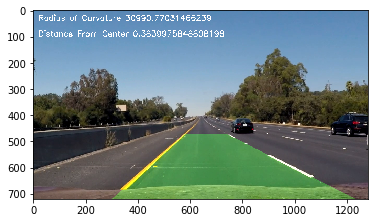

In [161]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(pipeline)
%time write_clip.write_videofile(write_output, audio=False)



### Discussion

#### Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

I started with finding the camera calibration matrix, it worked pretty well. Later derived the undistorted image. 
Then I applied perspective transformation on the image to get the warped image. I tried different source points in this case, previously it was able to determine only some part of the lanes, then I had to tweak the points (source and destination both) to come up with proper warped image. I tried with many sets of points and did the same on straight lines, later tested on curved lanes also. 

Then I found the lane pixels to get the boundary of the lanes, which I warped on the original image. Also, determined the curvature and position of the vehicle with respect to the center. 


Saved the images in the "output_images" folder. 
Video name is "project_video_out.mp4"


My pipeline may not work properly for few image where the lane lines in the top corner is not properly visible or because of the light. It might wobble some, but it wont be out of the path. It can be further improved to smoothen the lane detection in this case. 

I tried this pipeline on the challenge video, but its not working. For further work, I can try to improve the pipeline which may work on the challenge video. Also, looks like I might need to use some other technique for the same like RANSAC algorithm. 

